# Figures for "Systematically comparing feature-based representations of intra-regional and inter-regional brain dynamics"

## Load python packages

In [1]:
import os
import numpy as np
import nibabel as nib
import pandas as pd

%load_ext rpy2.ipython

## Load R Packages

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(colorspace)
    library(ComplexHeatmap)
    library(correctR)
    library(cowplot)
    library(dendextend)
    library(factoextra)
    library(FactoMineR)
    library(ggnewscale)
    library(ggpp)
    library(ggpubr)
    library(ggraph)
    library(ggridges)
    library(ggseg)
    library(ggsegDefaultExtra)
    library(ggsegHO)
    library(ggsignif)
    library(glue)
    library(igraph)
    library(LaCroixColoR)
    library(patchwork)
    library(psych)
    library(RColorBrewer)
    library(rlist)
    library(scales)
    library(see)
    library(splitstackshape)
    library(tidyverse)
    library(viridis)
})


# Set cowplot theme
theme_set(theme_cowplot())

## Load data needed for this analysis

In [3]:
# Load information about the time-series features
univariate_TS_feature_info = pd.read_csv("data/feature_info/univariate_feature_info.csv")
pairwise_TS_feature_info = pd.read_csv("data/feature_info/pairwise_feature_info.csv")

# Define SVM kernel type
SVM_kernel = "Linear"

# Name the feature sets
univariate_feature_set = "catch25"
pairwise_feature_set = "pyspi14"

# Load participants included
UCLA_CNP_subjects_to_keep = pd.read_feather("data/time_series_features/UCLA_CNP_filtered_sample_info_catch25_pyspi14.feather")
ABIDE_subjects_to_keep = pd.read_feather("data/time_series_features/ABIDE_filtered_sample_info_catch25_pyspi14.feather")

UCLA_CNP_metadata = (pd.read_feather("data/input_data/UCLA_CNP_sample_metadata.feather")
                        .assign(Study = "UCLA_CNP")
                        .query("Sample_ID in @UCLA_CNP_subjects_to_keep.Sample_ID"))
ABIDE_metadata = (pd.read_feather("data/input_data/ABIDE_sample_metadata.feather")
                        .assign(Study = "ABIDE")
                        .query("Sample_ID in @ABIDE_subjects_to_keep.Sample_ID"))

# Load intra-regional time-series features per disorder
UCLA_CNP_intra_regional_feature_data = (pd.read_feather("data/time_series_features/UCLA_CNP_catch25_filtered.feather")
                                        .merge(UCLA_CNP_metadata)
                                        .query("Sample_ID in @UCLA_CNP_subjects_to_keep.Sample_ID"))
ABIDE_intra_regional_feature_data = (pd.read_feather("data/time_series_features/ABIDE_catch25_filtered.feather")
                                        .merge(ABIDE_metadata)
                                        .query("Sample_ID in @ABIDE_subjects_to_keep.Sample_ID"))

# Load balanced accuracy, null distributions, fold assignments, and p-values
all_balanced_accuracy_results = pd.read_feather('data/classification_results/all_balanced_accuracy_results.feather')
all_null_distributions = pd.read_feather('data/classification_results/all_null_distributions.feather')
all_fold_assignments = pd.read_feather('data/classification_results/all_fold_assignments.feather')
all_p_values = pd.read_feather('data/classification_results/all_p_values.feather')

# TODO: fix how this is generated
balanced_accuracy_with_vs_without_inv_prob_weighting = (pd.read_feather("data/classification_results/SVM_with_vs_without_inv_prob_weighting.feather"))

# Load L1-regularized SVM balanced accuracy
all_L1_regularized_balanced_accuracy_results = pd.read_feather('data/classification_results/all_L1_regularized_balanced_accuracy_results.feather')

# Load PCA scores and balanced accuracy
univariate_combo_first25_PCs = pd.read_feather("data/time_series_features/univariate_combo_first25_PCs.feather")
univariate_combo_first25_PCs_balanced_accuracy = pd.read_feather("data/classification_results/all_PCA_balanced_accuracy_results.feather")


In [4]:
%%R -i all_balanced_accuracy_results -o UCLA_CNP_brain_region_info,ABIDE_brain_region_info,study_group_df,all_balanced_accuracy_results_across_folds,aparc_aseg_LUT

# Load brain region info
UCLA_CNP_brain_region_info <- read.csv("data/input_data/UCLA_CNP_Brain_Region_info.csv")
ABIDE_brain_region_info <- read.table("data/input_data/ABIDE_Brain_Region_info.txt", sep=";", header = T) %>%
  mutate(Brain_Region = ifelse(Index==45, "Heschl's Gyrus (includes H1 and H2)", Brain_Region))

aparc_aseg_LUT <- read.table("data/input_data/FreeSurferLUT.txt",
                             header=T) %>%
  dplyr::rename("ROI_Index" = "Value")

# Aggregate balanced accuracy results across folds
all_balanced_accuracy_results_across_folds <- all_balanced_accuracy_results %>%
  group_by(Study, Disorder, Analysis_Type, group_var) %>%
  reframe(Balanced_Accuracy_Across_Folds = mean(Balanced_Accuracy, na.rm=T),
          Balanced_Accuracy_Across_Folds_SD = sd(Balanced_Accuracy, na.rm=T),
          Training_Balanced_Accuracy_Across_Folds = mean(Training_Balanced_Accuracy, na.rm=T))

# Compile a study lookup table
study_group_df <- data.frame(Study = c(rep("UCLA_CNP", 3), "ABIDE"),
                              Disorder = c("SCZ", "BP", "ADHD", "ASD"))

In [5]:
%%R 
# Source helper functions
source("code/data_visualization/visualization_helper_functions.R")

# Figure 1: Methods

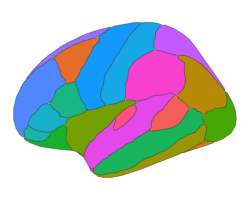

In [6]:
%%R -w 250 -h 200

# Plot an example brain
ggplot() +
  geom_brain(atlas = dk, hemi="left", side="lateral", color="gray30") +
  theme_void() + 
  theme(legend.position="none")


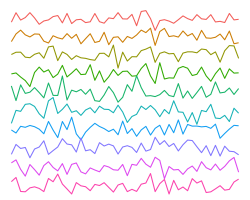

In [7]:
%%R -w 250 -h 200

# Plot a few example time-series
example_MTS <- as.data.frame(matrix(data=rnorm(500), nrow=50, ncol=10)) %>%
  mutate(Timepoint = 1:50) %>%
  pivot_longer(cols=c(-Timepoint), names_to = "Brain_Region", values_to="BOLD") %>%
  mutate(Brain_Region = as.factor(as.numeric(gsub("V", "", Brain_Region))))

example_MTS %>%
  ggplot(mapping=aes(x=Timepoint, y=BOLD, color=Brain_Region)) +
  geom_line() + 
  facet_grid(Brain_Region ~ .) +
  theme_void() +
  theme(legend.position = "none",
        strip.text = element_blank(),
        panel.spacing = unit(-1, "lines"))


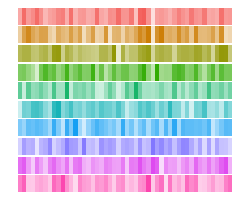

In [8]:
%%R -w 250 -h 200

# Plot as an example MTS heatmap
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

MTS_heatmap_list <- list()
MTS_colors <- gg_color_hue(10)
for (i in 1:length(unique(example_MTS$Brain_Region))) {
  roi = unique(example_MTS$Brain_Region)[i]
  roi_color = MTS_colors[i]
  roi_p <- example_MTS %>%
    filter(Brain_Region == roi) %>%
    ggplot(mapping=aes(x=Timepoint, fill=BOLD, y=0)) +
    geom_tile() + 
    theme_void() +
    scale_fill_gradient(low=alpha(roi_color, 0.2), high=roi_color) +
    theme(legend.position = "none")
  MTS_heatmap_list[[roi]] <- roi_p
}
wrap_plots(MTS_heatmap_list, ncol=1)


merging atlas and data by 'atlas', 'type', 'hemi', 'side', 'region', 'label', 'roi'


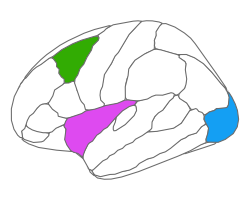

In [9]:
%%R -w 250 -h 200
# Example brain with regions highlighted
dk %>%
  as_tibble() %>%
  mutate(fillval = case_when(label == "lh_caudalmiddlefrontal" ~ "1",
                             label == "lh_insula" ~ "2",
                             label == "lh_lateraloccipital" ~ "3", 
                             T ~ NA_character_)) %>%
  ggseg(atlas = "dk", mapping = aes(fill = fillval),
        hemisphere="left",
        view = "lateral",
        position = "stacked", colour = "gray50") +
  scale_fill_manual(values=c("#39b600", "#e76bf3", "#00b0f6"),
                    na.value="white") +
  theme_void() +
  theme(plot.title = element_blank(),
        legend.position = "none")


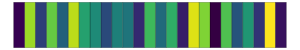

In [10]:
%%R -w 300 -h 50
# Sample feature vector
data.frame(x=sample(1:25),
           y=as.character(1:25)) %>%
  ggplot(data=., mapping=aes(x=x, y=0, fill=y)) +
  geom_tile(color="black") +
  scale_fill_viridis_d() +
  theme_void() +
  theme(legend.position = "none")

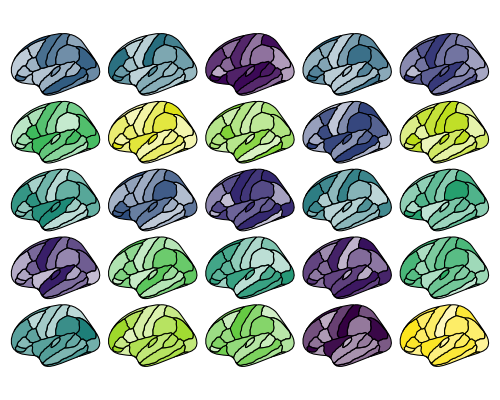

In [11]:
%%R -w 500 -h 400

# Brains with all 25 features [simulated data]
brain_colors <- viridis::viridis(25)

plots <- sample(1:25) %>%
  purrr::map(~ suppressMessages(plot_feature_in_brain(fill_color_gradient=brain_colors[.x], 
                                                      region_label="all")))
wrap_plots(plots, nrow=5)

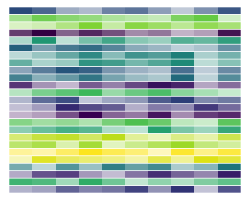

In [12]:
%%R -w 250 -h 200

# Plot feature X region matrix
feature_vec_plot_list <- list()
for (i in sample(1:25)) {
  p <- suppressWarnings(data.frame(x=sample(1:10),
             y=as.character(1:10)) %>%
    ggplot(data=., mapping=aes(x=y, y=0, fill=x)) +
    geom_raster(color="black") +
    scale_fill_gradientn(colors=c(alpha(brain_colors[i], 0.3), 
                                  brain_colors[i]), 
                         na.value=NA) +
    theme_void() +
    theme(legend.position = "none"))
  feature_vec_plot_list <- list.append(feature_vec_plot_list, p)
}

wrap_plots(feature_vec_plot_list, ncol=1)

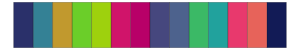

In [13]:
%%R -w 300 -h 50
# Sample pairwise feature vector
pyspi_colors <- unname(lacroix_palette("PassionFruit",14))
data.frame(x=sample(1:14),
           y=as.character(1:14)) %>%
  ggplot(data=., mapping=aes(x=x, y=0, fill=y)) +
  geom_tile(color="black") +
  scale_fill_manual(values=pyspi_colors) +
  theme_void() +
  theme(legend.position = "none")

R[write to console]: In addition: 
R[write to console]: There were 13 warnings (use warnings() to see them)
R[write to console]: 



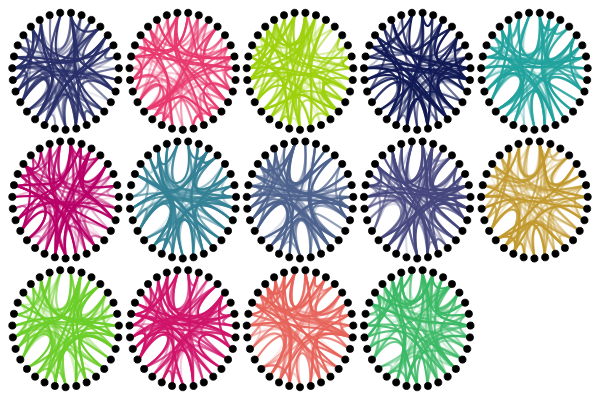

In [14]:
%%R -w 600 -h 400

# Example network graph
set.seed(127)

# Data for all pairwise connection graphs
# Edges are defined as cortical lobe --> specific ROI connection
edges <- read.csv("code/data_visualization/region_node_hierarchy.csv") %>% distinct()
# ROIs don't include the origin --> cortical lobe connection
rois <- edges %>% filter(!(to %in% c("Cingulate", "Frontal", "Insula",
                                     "Occipital", "Parietal", "Temporal")))
# Create a dataframe of vertices, one line per object in the ROI cortical lobe hierarchy
vertices = data.frame(name = unique(c(as.character(edges$from), as.character(edges$to))))
vertices$group <- edges$from[match(vertices$name, edges$to)]
# Create an igraph object
mygraph <- graph_from_data_frame(edges, vertices=vertices)

# plot_network_data is defined in visualization_helper_functions.R
plots <- sample(1:14) %>%
  purrr::map(~ plot_network_data(pyspi_colors[.x]))
wrap_plots(plots, nrow=3)

# Note that sometimes the network plots come out a bit wonky and need to be manually edited in Inkscape or similar


# Figure 2: Local properties of BOLD dynamics in individual brain regions can meaningfully distinguish cases versus controls

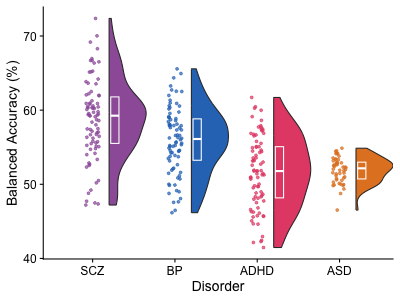

In [15]:
%%R  -i all_p_values -w 400 -h 300

all_p_values %>%
  filter(Analysis_Type == "Univariate_Brain_Region")   %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Disorder, y=100*Balanced_Accuracy_Across_Folds,
                             fill=Disorder)) +
  geom_violinhalf(aes(fill=Disorder), scale="width", 
                  position = position_nudge(x=0.2))  +
  geom_boxplot(width=0.1, notch=FALSE, notchwidth = 0.4, outlier.shape = NA,
               fill=NA, color="white",
               position = position_nudge(x=0.27), coef = 0) +
  geom_point(aes(color = Disorder), position = position_jitterdodge(dodge.width = 1,
                                                                            jitter.width = 0.5),
             size = 1, alpha=0.7) +
  scale_color_manual(values = c("SCZ" = "#9d60a8", 
                                "BP" = "#2F77C0", 
                                "ADHD" = "#e45075", 
                                "ASD" = "#E28328")) +
  scale_fill_manual(values = c("SCZ" = "#9d60a8", 
                               "BP" = "#2F77C0", 
                               "ADHD" = "#e45075", 
                               "ASD" = "#E28328")) +
  theme(legend.position = "none") +
  xlab("Disorder") +
  ylab("Balanced Accuracy (%)")

merging atlas and data by 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'


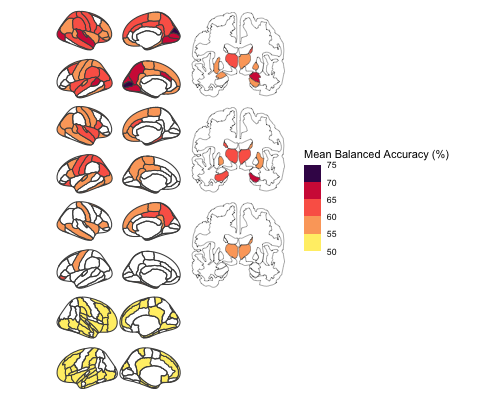

In [16]:
%%R -i all_p_values -o significant_univariate_region_wise_results -w 500 -h 400

# Define dataset with univariate region-wise results
significant_univariate_region_wise_results <- all_p_values %>%
  filter(Analysis_Type == "Univariate_Brain_Region") %>%
  filter(p_value_HolmBonferroni < 0.05) %>%
  mutate(Balanced_Accuracy_Across_Folds = 100*Balanced_Accuracy_Across_Folds)

# Save the resulting significant region performance to a CSV file
all_p_values %>%
  filter(Analysis_Type=="Univariate_Brain_Region",
         p_value_HolmBonferroni < 0.05) %>%
  dplyr::select(Disorder, group_var, p_value_HolmBonferroni, Balanced_Accuracy_Across_Folds, Balanced_Accuracy_Across_Folds_SD) %>%
  dplyr::rename("Brain Region" = "group_var") %>%
  mutate(Balanced_Accuracy_Across_Folds = round(100*Balanced_Accuracy_Across_Folds,1),
         Balanced_Accuracy_Across_Folds_SD = round(100*Balanced_Accuracy_Across_Folds_SD,1),
         p_value_HolmBonferroni = format(p_value_HolmBonferroni, digits=1)) %>%
  dplyr::rename("Balanced Accuracy" = "Balanced_Accuracy_Across_Folds",
                "SD" = "Balanced_Accuracy_Across_Folds_SD",
                "Holm--Bonferroni p-value" = "p_value_HolmBonferroni") %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ungroup() %>%
  arrange(Disorder, desc(`Balanced Accuracy`)) %>%
  dplyr::select(Disorder, `Brain Region`, `Balanced Accuracy`, `SD`, `Holm--Bonferroni p-value`) %>%
  write.csv(., "plots/tables/Table_S3_significant_univariate_region_wise_results.csv", row.names = F)

catch25_region_wise_balacc_plot_list <- suppressMessages(plot_balacc_in_brain(significant_univariate_region_wise_results=significant_univariate_region_wise_results,
                                                                              study_group_df=study_group_df,
                                                                              bin_seq_range=seq(50,75,by=5),
                                                                              ABIDE_brain_region_info=ABIDE_brain_region_info))
wrap_plots(catch25_region_wise_balacc_plot_list, 
           ncol=2, 
           byrow=T) + 
  plot_layout(guides = "collect")
 

In [17]:
# Save the resulting significant region performance to a CSV file
significant_univariate_region_wise_results.to_csv("data/classification_results/significant_univariate_region_wise_results.csv")

# We can get the number of significant regions per disorder
significant_univariate_region_wise_results['Disorder'].value_counts()

Disorder
SCZ     65
BP      45
ASD     28
ADHD    18
Name: count, dtype: int64

# Figure 3: Analysis with individual time-series features measured across the brain highlights diverse differences in brain-wide dynamics across clinical groups

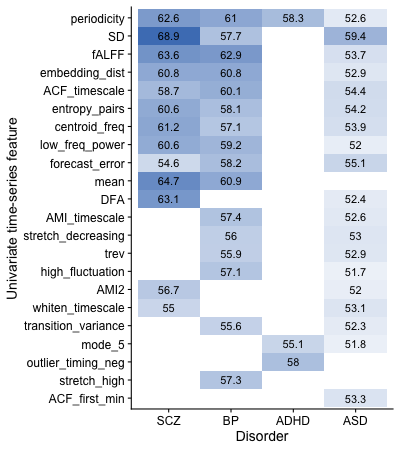

In [18]:
%%R -i all_p_values,univariate_TS_feature_info -w 400 -h 450

# Save the significant feature performance to a CSV file
all_p_values %>%
  filter(Analysis_Type=="Univariate_TS_Feature",
         p_value_HolmBonferroni < 0.05) %>%
  dplyr::rename("feature_name" = "group_var") %>%
  left_join(., univariate_TS_feature_info, by="feature_name") %>%
  dplyr::select(Disorder, Figure_name, p_value_HolmBonferroni, Balanced_Accuracy_Across_Folds, Balanced_Accuracy_Across_Folds_SD) %>%
  dplyr::rename("Time-series feature" = "Figure_name") %>%
  mutate(Balanced_Accuracy_Across_Folds = round(100*Balanced_Accuracy_Across_Folds,1),
         Balanced_Accuracy_Across_Folds_SD = round(100*Balanced_Accuracy_Across_Folds_SD,1),
         p_value_HolmBonferroni = format(p_value_HolmBonferroni, digits=1)) %>%
  dplyr::rename("Balanced Accuracy" = "Balanced_Accuracy_Across_Folds",
                "SD" = "Balanced_Accuracy_Across_Folds_SD",
                "Holm--Bonferroni p-value" = "p_value_HolmBonferroni") %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ungroup() %>%
  arrange(Disorder, desc(`Balanced Accuracy`)) %>%
  dplyr::select(Disorder, `Time-series feature`, `Balanced Accuracy`, `SD`, `Holm--Bonferroni p-value`) %>%
  write.csv(., "plots/tables/Table_S4_significant_univariate_time_series_feature_wise_results.csv", row.names = F)

# Balanced accuracy heatmap
all_p_values %>%
  filter(Analysis_Type == "Univariate_TS_Feature") %>%
  dplyr::rename("feature_name" = "group_var") %>%
  left_join(., univariate_TS_feature_info, by="feature_name") %>%
  filter(p_value_HolmBonferroni<0.05) %>%
  mutate(Balanced_Accuracy_Across_Folds = 100*Balanced_Accuracy_Across_Folds) %>%
  mutate(Figure_name = fct_reorder(Figure_name, Balanced_Accuracy_Across_Folds, .fun=sum),
         Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Disorder, y=Figure_name, 
                             fill=Balanced_Accuracy_Across_Folds)) +
  geom_tile()+
  geom_text(aes(label = round(Balanced_Accuracy_Across_Folds, 1))) +
  scale_fill_gradientn(colors=c(alpha("#4C7FC0", 0.1), "#4C7FC0"), 
                       na.value=NA) +
  labs(fill = "Mean Balanced Accuracy (%)") +
  xlab("Disorder") +
  ylab("Univariate time-series feature") +
  theme(legend.position="none",
        strip.background = element_blank(),
        strip.text = element_blank())


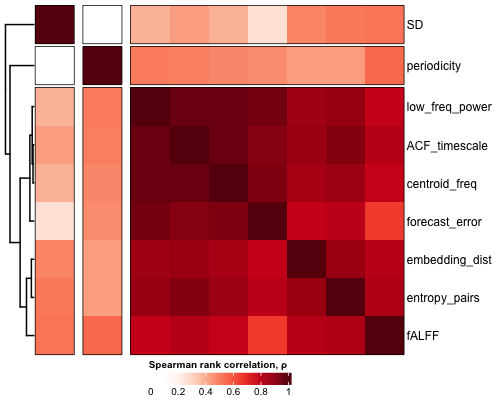

In [19]:
%%R -i all_p_values,univariate_TS_feature_info,univariate_feature_set,UCLA_CNP_intra_regional_feature_data,ABIDE_intra_regional_feature_data -o top_feature_values_wide,data_for_corr_long -w 500 -h 400

# Create adjacency matrix of feature values across all participants
top_features <- all_p_values %>%
  filter(Analysis_Type == "Univariate_TS_Feature") %>%
  group_by(group_var) %>%
  filter(sum(p_value_HolmBonferroni<0.05)>=3) %>%
  summarise(sum_balacc = sum(Balanced_Accuracy_Across_Folds)) %>%
  slice_max(sum_balacc, n=10) %>%
  pull(group_var)

# Calculate the absolute Spearman correlation between each pair of features
feature_values_corr <- plyr::rbind.fill(UCLA_CNP_intra_regional_feature_data, ABIDE_intra_regional_feature_data) %>%
  mutate(unique_ID = paste0(Sample_ID, "__", Brain_Region), .keep="unused") %>%
  left_join(., univariate_TS_feature_info, by=c("names"="feature_name")) %>%
  dplyr::select(unique_ID, Figure_name, values) %>%
  pivot_wider(id_cols=unique_ID, names_from=Figure_name, values_from=values) %>%
  dplyr::select(-unique_ID) %>%
  psych::corr.test(method="spearman", adjust="holm")

top_feature_values_wide <- plyr::rbind.fill(UCLA_CNP_intra_regional_feature_data, ABIDE_intra_regional_feature_data) %>%
  filter(names %in% top_features) %>%
  mutate(unique_ID = paste0(Sample_ID, "__", Brain_Region), .keep="unused") %>%
  left_join(., univariate_TS_feature_info, by=c("names"="feature_name")) %>%
  dplyr::select(unique_ID, Figure_name, values) %>%
  pivot_wider(id_cols=unique_ID, names_from=Figure_name, values_from=values)
  
top_feature_values_corr <- top_feature_values_wide  %>%
  dplyr::select(-unique_ID) %>%
  psych::corr.test(method="spearman", adjust="holm")

# Convert to long for easy querying
data_for_corr_long <- feature_values_corr$r %>%
  as.data.frame() %>%
  rownames_to_column(var="feature1") %>%
  pivot_longer(cols=c(-feature1), names_to="feature2", values_to="spearman_corr_abs")

# Define two branches for the dendrogram
num_branches <- 3

# Draw the heatmap
ht1 <- ComplexHeatmap::Heatmap(abs(top_feature_values_corr$r),
                               clustering_distance_rows = "spearman",
                               clustering_distance_columns = "spearman",
                               clustering_method_rows = "average",
                               clustering_method_columns = "average",
                               row_names_side = "right",
                               row_dend_side = "left", 
                               row_dend_width = unit(1, "cm"),
                               row_dend_gp = gpar(lwd=unit(2, "cm")),
                               row_split = num_branches,
                               column_split = num_branches,
                               column_gap = unit(3, "mm"),
                               row_title = NULL,
                               column_title = NULL,
                               show_row_names = TRUE,
                               show_column_names = FALSE,
                               show_column_dend = FALSE,
                               border = TRUE,
                               col = c("white", brewer.pal(9, "Reds")),
                               name = "Spearman rank correlation, \u03c1",
                               heatmap_legend_param = list(legend_direction = "horizontal",
                                                           legend_width = unit(5, "cm")))

suppressWarnings(draw(ht1, heatmap_legend_side = "bottom",
                      background = "transparent"))

Joining with `by = join_by(Study, Disorder)`


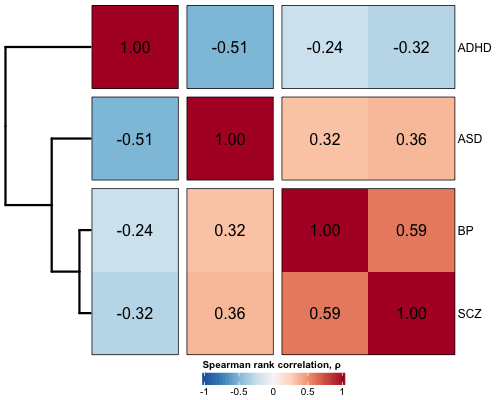

In [20]:
%%R -i all_p_values,study_group_df  -w 500 -h 400
 
# How are different disorders correlated in terms of classification accuracy by univariate intra-regional time-series feature?

feature_accuracy_corr <- all_p_values %>%
  filter(Analysis_Type=="Univariate_TS_Feature") %>%
  left_join(., study_group_df) %>%
  dplyr::select(group_var, Disorder, Balanced_Accuracy_Across_Folds) %>%
  pivot_wider(id_cols=group_var, names_from=Disorder, values_from=Balanced_Accuracy_Across_Folds) %>%
  dplyr::select(-group_var) %>%
  psych::corr.test(method="spearman", adjust="holm")

num_branches <- 3
ht2 <- ComplexHeatmap::Heatmap(feature_accuracy_corr$r,
                               clustering_distance_rows = "spearman",
                               clustering_distance_columns = "spearman",
                               clustering_method_rows = "average",
                               clustering_method_columns = "average",
                               row_names_side = "right",
                               row_dend_side = "left", 
                               row_dend_width = unit(3, "cm"),
                               row_dend_gp = gpar(lwd=unit(3, "cm")),
                               row_split = num_branches,
                               row_gap = unit(3, "mm"),
                               column_split = num_branches,
                               column_gap = unit(3, "mm"),
                               row_title = NULL,
                               column_title = NULL,
                               show_row_names = TRUE,
                               show_column_names = FALSE,
                               show_column_dend = FALSE,
                               border = TRUE,
                               cell_fun = function(j, i, x, y, width, height, fill) {
                                 grid.text(sprintf("%.2f", feature_accuracy_corr$r[i, j]), x, y, gp = gpar(fontsize = 16))
                               },
                               col = colorRamp2(seq(-1, 1, length.out=9), brewer_pal("div", "RdBu", direction=-1)(9)),
                               name = "Spearman rank correlation, \u03c1",
                               heatmap_legend_param = list(legend_direction = "horizontal",
                                                           legend_width = unit(5, "cm")))

suppressWarnings(draw(ht2, heatmap_legend_side = "bottom",
                      background = "transparent"))

# Figure 4: Representing a multivariate fMRI time series with whole-brain maps of univariate features improves classification performance for BP, but not for SCZ, ADHD, or ASD—for which simpler representations are better suited

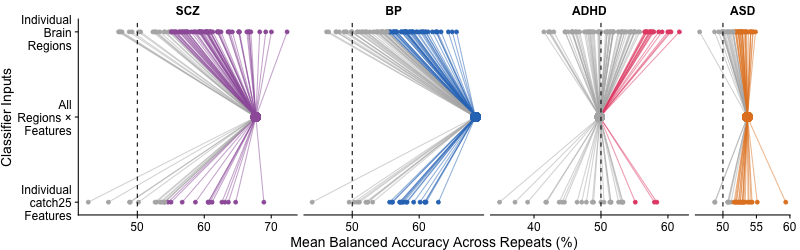

In [21]:
%%R -i all_p_values -w 800 -h 250

# Save the significant combination classifier results to a CSV file
all_p_values %>%
  filter(Analysis_Type=="Univariate_Combo",
         p_value_HolmBonferroni < 0.05) %>%
  dplyr::select(Disorder, p_value_HolmBonferroni, Balanced_Accuracy_Across_Folds, Balanced_Accuracy_Across_Folds_SD) %>%
  dplyr::mutate("Analysis" = "A[combo]") %>%
  mutate(Balanced_Accuracy_Across_Folds = round(100*Balanced_Accuracy_Across_Folds,1),
         Balanced_Accuracy_Across_Folds_SD = round(100*Balanced_Accuracy_Across_Folds_SD,1),
         p_value_HolmBonferroni = format(p_value_HolmBonferroni, digits=1)) %>%
  dplyr::rename("Balanced Accuracy" = "Balanced_Accuracy_Across_Folds",
                "SD" = "Balanced_Accuracy_Across_Folds_SD",
                "Holm--Bonferroni p-value" = "p_value_HolmBonferroni") %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ungroup() %>%
  arrange(Disorder, desc(`Balanced Accuracy`)) %>%
  dplyr::select(Disorder, Analysis, `Balanced Accuracy`, `SD`, `Holm--Bonferroni p-value`) %>%
  write.csv(., "plots/tables/Table_S5_significant_univariate_combo_wise_results.csv", row.names = F)

# Summarise performance metrics
all_p_values %>%
  filter(Analysis_Type == "Univariate_Combo") %>% 
  mutate(summarymean = round(Balanced_Accuracy_Across_Folds*100,1),
         summarysd = round(Balanced_Accuracy_Across_Folds_SD*100,1)) %>%
  dplyr::select(Disorder, summarymean, summarysd) %>%
  arrange(desc(summarymean))

# Bowtie plot comparing each brain region and feature to combo-wise performance
num_comparisons <- all_p_values %>%
  filter(Analysis_Type %in% c("Univariate_Brain_Region", "Univariate_TS_Feature")) %>%
  group_by(Study, Disorder) %>%
  count()

all_p_values %>%
  filter(Analysis_Type == "Univariate_Combo") %>% 
  left_join(., num_comparisons, by = join_by(Study, Disorder)) %>%
  expandRows("n") %>%
  group_by(Study, Disorder) %>%
  mutate(group_ID = paste0(Disorder, "_", row_number())) %>%
  plyr::rbind.fill(., all_p_values %>%
  filter(Analysis_Type %in% c("Univariate_Brain_Region", "Univariate_TS_Feature")) %>%
                     group_by(Study, Disorder) %>%
                     mutate(group_ID = paste0(Disorder, "_", row_number()))) %>%
  rowwise() %>%
  mutate(Analysis_Label = case_when(Analysis_Type == "Univariate_Combo" ~ "All\nRegions \u00D7\nFeatures",
                                    Analysis_Type == "Univariate_TS_Feature" ~ "Individual\ncatch25\nFeatures",
                                    T ~ "Individual\nBrain\nRegions"),
         Analysis_Sig = paste0(Disorder, "_", p_value_HolmBonferroni < 0.05)) %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD")),
         Analysis_Label = factor(Analysis_Label, levels = c("Individual\ncatch25\nFeatures",
                                                            "All\nRegions \u00D7\nFeatures",
                                                            "Individual\nBrain\nRegions"))) %>%
  group_by(Study, Disorder, group_ID) %>%
  mutate(Comparison_Sig = paste0(Disorder, "_", p_value_HolmBonferroni[Analysis_Type != "Univariate_Combo"]<0.05)) %>% 
  ggplot(data=., mapping=aes(x=Analysis_Label, y=100*Balanced_Accuracy_Across_Folds, 
                             group=group_ID, color=Comparison_Sig)) +
  geom_line(alpha=0.5) +
  geom_point(aes(size=Analysis_Type, color=Analysis_Sig)) +
  ylab("Mean Balanced Accuracy Across Repeats (%)") +
  xlab("Classifier Inputs") +
  geom_hline(yintercept = 50, linetype=2) +
  scale_x_discrete(expand=c(0.05,0.05,0.05,0.05)) +
  scale_size_manual(values=c("Univariate_Combo"=4,
                             "Univariate_TS_Feature"=1.5,
                             "Univariate_Brain_Region" = 1.5)) +
  scale_color_manual(values = c("SCZ_TRUE"="#9d60a8", 
                                "BP_TRUE"="#2F77C0", 
                                "ADHD_TRUE"="#e45075",
                                "ASD_TRUE"="#E28328",
                                "SCZ_FALSE"="gray70", 
                                "BP_FALSE"="gray70", 
                                "ADHD_FALSE"="gray70",
                                "ASD_FALSE"="gray70")) +
  facet_grid(. ~ Disorder, scales="free_x", space="free") +
  theme(legend.position = "none",
        plot.margin = margin(1,10,1,1),
        strip.background = element_blank(),
        strip.text = element_text(face="bold")) + 
  coord_flip()


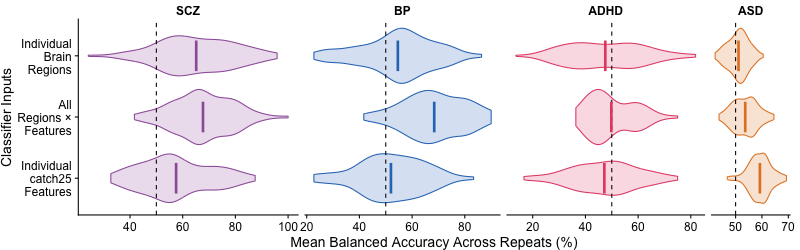

In [22]:
%%R -i all_balanced_accuracy_results -o intra_regional_balanced_accuracy_best_from_in_sample -w 800 -h 250

# Take only the top-performing region and time-series feature from training data folds
intra_regional_balanced_accuracy_best_from_in_sample_all_folds <- all_balanced_accuracy_results %>%
  filter(Analysis_Type %in% c("Univariate_Brain_Region", "Univariate_TS_Feature", "Univariate_Combo")) %>%
  group_by(Study, Disorder, Analysis_Type, Fold, Repeat_Number) %>%
  filter(Training_Balanced_Accuracy==max(Training_Balanced_Accuracy)) %>%
  ungroup() %>%
  group_by(Study, Disorder, Analysis_Type) %>%
  mutate(Mean_CV_Balanced_Accuracy_Overall = mean(Balanced_Accuracy),
         SD_Balanced_Accuracy_Overall = sd(Balanced_Accuracy)) 
intra_regional_balanced_accuracy_best_from_in_sample <- intra_regional_balanced_accuracy_best_from_in_sample_all_folds %>%
  group_by(Study, Disorder, Analysis_Type, group_var, Mean_CV_Balanced_Accuracy_Overall) %>%
  reframe(percent_of_100 = n()/100)

# Violin plot
intra_regional_balanced_accuracy_best_from_in_sample_all_folds %>%
  mutate(Analysis_Label = case_when(Analysis_Type == "Univariate_Combo" ~ "All\nRegions \u00D7\nFeatures",
                                    Analysis_Type == "Univariate_TS_Feature" ~ "Individual\ncatch25\nFeatures",
                                    T ~ "Individual\nBrain\nRegions")) %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD")),
         Analysis_Label = factor(Analysis_Label, levels = c("Individual\ncatch25\nFeatures",
                                                            "All\nRegions \u00D7\nFeatures",
                                                            "Individual\nBrain\nRegions"))) %>%
  ggplot(data=., mapping=aes(x=Analysis_Label, y=100*Balanced_Accuracy, 
                             fill=Disorder, color = Disorder)) +
  geom_violin(alpha=0.2) +
  facet_grid(. ~ Disorder, scales="free", space="free") +
  ylab("Mean Balanced Accuracy Across Repeats (%)") +
  xlab("Classifier Inputs") +
  geom_hline(yintercept = 50, linetype=2) +
  stat_summary(fun = "mean",
               geom = "crossbar", 
               width = 0.5) +
  scale_fill_manual(values = c("SCZ"="#9d60a8", 
                                "BP"="#2F77C0", 
                                "ADHD"="#e45075",
                                "ASD"="#E28328")) +
  scale_color_manual(values = c("SCZ"="#9d60a8", 
                                "BP"="#2F77C0", 
                                "ADHD"="#e45075",
                                "ASD"="#E28328")) +
  theme(legend.position = "none",
        plot.margin = margin(1,10,1,1),
        strip.background = element_blank(),
        strip.text = element_text(face="bold")) + 
  coord_flip()

In [23]:
%%R -i intra_regional_balanced_accuracy_best_from_in_sample,univariate_TS_feature_info

# What are the top-performing regions and features in general by disorder?

intra_regional_balanced_accuracy_best_from_in_sample %>%
  group_by(Disorder, Analysis_Type) %>%
  top_n(n=1, wt=percent_of_100) %>%
  left_join(., univariate_TS_feature_info, by=c("group_var"="feature_name")) %>%
  dplyr::select(Disorder, Analysis_Type, group_var, Figure_name, percent_of_100)

# A tibble: 12 × 5
# Groups:   Disorder, Analysis_Type [12]
   Disorder Analysis_Type           group_var         Figure_name percent_of_100
   <chr>    <chr>                   <chr>             <chr>                <dbl>
 1 ASD      Univariate_Brain_Region Parahippocampal … <NA>                  0.19
 2 ASD      Univariate_Combo        Combo             <NA>                  1   
 3 ASD      Univariate_TS_Feature   DN_Spread_Std     SD                    0.99
 4 ADHD     Univariate_Brain_Region ctx-rh-precuneus  <NA>                  0.22
 5 ADHD     Univariate_Combo        Combo             <NA>                  1   
 6 ADHD     Univariate_TS_Feature   SC_FluctAnal_2_r… rs_range              0.63
 7 BP       Univariate_Brain_Region Right-Hippocampus <NA>                  0.34
 8 BP       Univariate_Combo        Combo             <NA>                  1   
 9 BP       Univariate_TS_Feature   PD_PeriodicityWa… periodicity           0.56
10 SCZ      Univariate_Brain_Region ctx-lh-perica

# Figure 5: Representing brain activity as the set of all pairwise functional connectivity strengths, $\mathrm{A_{FC}}$, can significantly distinguish cases from controls—with the classical Pearson correlation coefficient as a top performer.

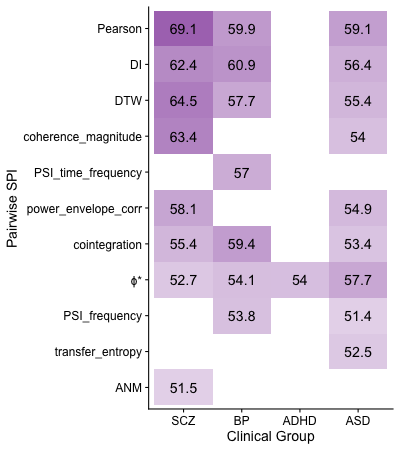

In [24]:
%%R -i all_p_values,pairwise_TS_feature_info -w 400 -h 450

# Save the significant SPI performance to a CSV file
all_p_values %>%
  filter(Analysis_Type=="Pairwise_SPI",
         p_value_HolmBonferroni < 0.05) %>%
  dplyr::rename("pyspi_name" = "group_var") %>%
  left_join(., pairwise_TS_feature_info, by="pyspi_name") %>%
  dplyr::select(Disorder, Figure_name, p_value_HolmBonferroni, Balanced_Accuracy_Across_Folds, Balanced_Accuracy_Across_Folds_SD) %>%
  dplyr::rename("SPI" = "Figure_name") %>%
  mutate(Balanced_Accuracy_Across_Folds = round(100*Balanced_Accuracy_Across_Folds,1),
         Balanced_Accuracy_Across_Folds_SD = round(100*Balanced_Accuracy_Across_Folds_SD,1),
         p_value_HolmBonferroni = format(p_value_HolmBonferroni, digits=1)) %>%
  dplyr::rename("Balanced Accuracy" = "Balanced_Accuracy_Across_Folds",
                "SD" = "Balanced_Accuracy_Across_Folds_SD",
                "Holm--Bonferroni p-value" = "p_value_HolmBonferroni") %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ungroup() %>%
  arrange(Disorder, desc(`Balanced Accuracy`)) %>%
  dplyr::select(Disorder, SPI, `Balanced Accuracy`, `SD`, `Holm--Bonferroni p-value`) %>%
  write.csv(., "plots/tables/Table_S6_significant_pairwise_SPI_wise_results.csv", row.names = F)

# Balanced accuracy heatmap
all_p_values %>%
  filter(Analysis_Type == "Pairwise_SPI",
         p_value_HolmBonferroni < 0.05) %>%
  dplyr::rename("pyspi_name" = "group_var") %>%
  left_join(., pairwise_TS_feature_info, by = join_by(pyspi_name)) %>%
  # Rename phi-star
  mutate(Figure_name = case_when(Figure_name == "phi_star" ~ "\u03D5*",
                                T ~ Figure_name)) %>%
  mutate(Disorder = case_when(Disorder == "Schizophrenia" ~ "SCZ",
                                      Disorder == "Bipolar" ~ "BP",
                                      T ~ Disorder),
         Balanced_Accuracy_Across_Folds = 100*Balanced_Accuracy_Across_Folds) %>%
  mutate(Figure_name = fct_reorder(Figure_name, Balanced_Accuracy_Across_Folds, .fun=mean),
         Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Disorder, y=Figure_name, 
                             fill=Balanced_Accuracy_Across_Folds)) +
  geom_tile()+
  geom_text(aes(label = round(Balanced_Accuracy_Across_Folds, 1)), size=5) +
  scale_fill_gradientn(colors=c(alpha("#AC77BD", 0.3), "#AC77BD"), 
                       na.value=NA)  + 
  scale_y_discrete(labels = wrap_format(28)) +
  labs(fill = "Mean Balanced Accuracy (%)") +
  xlab("Clinical Group") +
  ylab("Pairwise SPI") +
  theme(legend.position="none")

In [25]:
%%script false --no-raise-error
# Create correlogram for top 10 SPIs if data file does not already exist
UCLA_CNP_pyspi14 = (pd.read_feather(f"{data_path}/UCLA_CNP/processed_data/UCLA_CNP_AROMA_2P_GMR_pyspi14_filtered.feather")
                    .merge(UCLA_CNP_metadata))
ABIDE_ASD_pyspi14 = (pd.read_feather(f"{data_path}/ABIDE_ASD/processed_data/ABIDE_ASD_FC1000_pyspi14_filtered.feather")
                    .merge(ABIDE_ASD_metadata))
    

In [26]:
%%script false --no-raise-error
%%R -i UCLA_CNP_pyspi14,ABIDE_ASD_pyspi14,pairwise_TS_feature_info,inter_regional_p_values -o data_for_corr_long

if (!(file.exists("data/time_series_features/SPI_performance_correlation_across_disorders.csv"))) {
  # Correlogram by SPI for 10 SPIs with significant balanced accuracies
  merged_pyspi14 <- plyr::rbind.fill(UCLA_CNP_pyspi14, ABIDE_ASD_pyspi14) %>%
    mutate(unique_ID = paste0(Sample_ID, "__", brain_region_from, "__", brain_region_to), .keep="unused") 

  # Create adjacency matrix of feature values across all participants
  unique_groups <- unique(merged_pyspi14$SPI)
  group_combinations <- combn(unique_groups, 2, simplify = FALSE)

  cor_list <- list()

  for (i in 1:length(group_combinations)) {
    group_pair <- sort(group_combinations[[i]])
    
    SPI1 <- group_pair[1]
    SPI2 <- group_pair[2]
    
    SPI1_data <- merged_pyspi14 %>% filter(SPI==SPI1) %>% pull(value)
    SPI2_data <- merged_pyspi14 %>% filter(SPI==SPI2) %>% pull(value)
    
    correlation_df <- data.frame(SPI1 = SPI1,
                                  SPI2 = SPI2,
                                  SPI1_nickname = SPI1_nickname,
                                  SPI2_nickname = SPI2_nickname,
                                  spearman_corr_abs = abs(cor(SPI1_data, SPI2_data, method = "spearman",  use="complete.obs")))
    
    cor_list <- list.append(cor_list, correlation_df)
    
    rm(SPI1_data)
    rm(SPI2_data)
    gc()
  }

  data_for_corr_long <- do.call(plyr::rbind.fill, cor_list)

  write.table(data_for_corr_long, "data/time_series_features/SPI_performance_correlation_across_disorders.csv", sep=",", row.names=F)
}


In [27]:
%%script false --no-raise-error
# can clear these objects from memory at this point
del UCLA_CNP_pyspi14, ABIDE_ASD_pyspi14

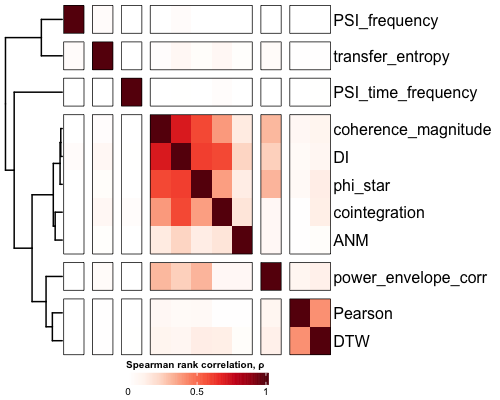

In [28]:
%%R -i all_p_values,pairwise_feature_set,pairwise_TS_feature_info -w 500 -h 400

# Read in SPI correlation data
data_for_corr_long <- read.table("data/time_series_features/SPI_performance_correlation_across_disorders.csv", sep=",", header=T)

sig_SPIs <- all_p_values %>%
  filter(Analysis_Type == "Pairwise_SPI",
         p_value_HolmBonferroni < 0.05) %>%
  distinct(group_var) %>%
  dplyr::rename("pyspi_name" = "group_var") %>%
  left_join(., pairwise_TS_feature_info, by = join_by(pyspi_name)) %>%
  pull(Figure_name)

# Convert to long for easy querying
data_for_corr_heatmap <- data_for_corr_long %>%
  plyr::rbind.fill(., data_for_corr_long %>% rename("SPI1_nickname"="SPI2_nickname", "SPI2_nickname"="SPI1_nickname")) %>%
  pivot_wider(id_cols=SPI1_nickname, names_from=SPI2_nickname, values_from=spearman_corr_abs) %>%
  column_to_rownames(var="SPI1_nickname") %>%
  select(all_of(sig_SPIs)) %>%
  dplyr::filter(row.names(.) %in% sig_SPIs) %>%
  as.matrix()
data_for_corr_heatmap[is.na(data_for_corr_heatmap)] <- 1

# Rearrange rows and columns
data_for_corr_heatmap <- data_for_corr_heatmap[sig_SPIs, sig_SPIs]

# Use six branches
num_branches <- 6

ht1 <- ComplexHeatmap::Heatmap(data_for_corr_heatmap,
                               clustering_distance_rows = "spearman",
                               clustering_distance_columns = "spearman",
                               clustering_method_rows = "average",
                               clustering_method_columns = "average",
                               row_names_side = "right",
                               row_dend_side = "left", 
                               row_dend_width = unit(2, "cm"),
                               row_dend_gp = gpar(lwd=unit(2, "cm")),
                               row_split = num_branches,
                               row_gap = unit(3, "mm"),
                               column_split = num_branches,
                               column_gap = unit(3, "mm"),
                               row_title = NULL,
                               column_title = NULL,
                               show_row_names = TRUE,
                               row_names_gp = grid::gpar(fontsize = 16),
                               show_column_names = FALSE,
                               show_column_dend = FALSE,
                               border = TRUE,
                               col = c("white", brewer.pal(9, "Reds")),
                               name = "Spearman rank correlation, \u03c1",
                               heatmap_legend_param = list(legend_direction = "horizontal",
                                                           legend_width = unit(5, "cm")))

suppressWarnings(draw(ht1, heatmap_legend_side = "bottom",
                      background = "transparent"))

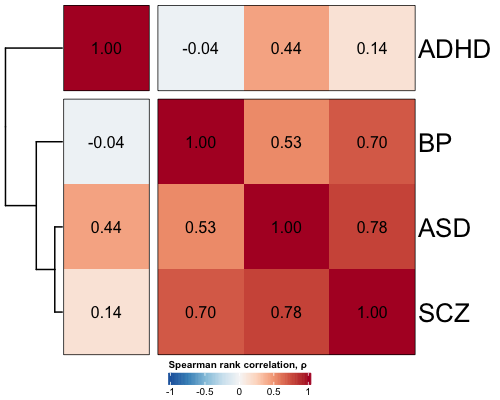

In [29]:
%%R -i all_p_values,study_group_df  -w 500 -h 400

# How are different disorders correlated in terms of classification accuracy by pairwise SPI?

SPI_accuracy_corr_data <- all_p_values %>%
  filter(Analysis_Type == "Pairwise_SPI") %>%
  left_join(., study_group_df, by = join_by(Study, Disorder)) %>%
  dplyr::select(group_var, Disorder, Balanced_Accuracy_Across_Folds) %>%
  pivot_wider(id_cols=group_var, names_from=Disorder, values_from=Balanced_Accuracy_Across_Folds) %>%
  dplyr::select(-group_var) %>%
  cor(method="spearman")

num_branches <- 2
ht2 <- ComplexHeatmap::Heatmap(SPI_accuracy_corr_data,
                               clustering_distance_rows = "spearman",
                               clustering_distance_columns = "spearman",
                               clustering_method_rows = "average",
                               clustering_method_columns = "average",
                               row_names_side = "right",
                               row_dend_side = "left", 
                               row_dend_width = unit(2, "cm"),
                               row_dend_gp = gpar(lwd=unit(2, "cm")),
                               row_split = num_branches,
                               row_gap = unit(3, "mm"),
                               column_split = num_branches,
                               column_gap = unit(3, "mm"),
                               row_title = NULL,
                               column_title = NULL,
                               show_row_names = TRUE,
                               row_names_gp = grid::gpar(fontsize = 26),
                               show_column_names = FALSE,
                               show_column_dend = FALSE,
                               border = TRUE,
                               cell_fun = function(j, i, x, y, width, height, fill) {
                                 grid.text(sprintf("%.2f", SPI_accuracy_corr_data[i, j]), x, y, gp = gpar(fontsize = 16))
                               },
                               col = colorRamp2(seq(-1, 1, length.out=9), brewer_pal("div", "RdBu", direction=-1)(9)),
                               name = "Spearman rank correlation, \u03c1",
                               heatmap_legend_param = list(legend_direction = "horizontal",
                                                           legend_width = unit(5, "cm")))


suppressWarnings(draw(ht2, heatmap_legend_side = "bottom",
                      background = "transparent"))

# Figure 6: Adding local regional dynamics enhances classification performance for many pairwise FC metrics.

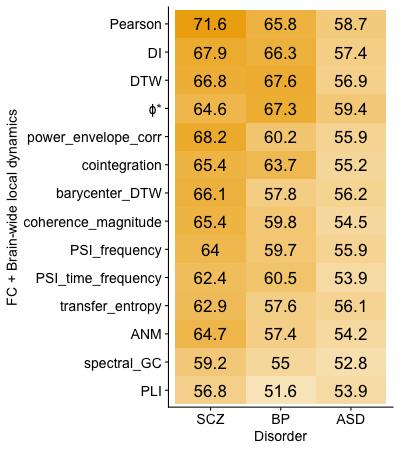

In [30]:
%%R -i all_p_values,pairwise_feature_set,pairwise_TS_feature_info -w 400 -h 450

# Save the resulting significant SPI performance to a CSV file 
all_p_values %>%
  filter(Analysis_Type=="Univariate_Pairwise_Combo",
         p_value_HolmBonferroni < 0.05) %>%
  dplyr::rename("pyspi_name" = "group_var") %>%
  left_join(., pairwise_TS_feature_info, by="pyspi_name") %>%
  dplyr::select(Disorder, Figure_name, p_value_HolmBonferroni, Balanced_Accuracy_Across_Folds, Balanced_Accuracy_Across_Folds_SD) %>%
  dplyr::rename("SPI with local dynamics" = "Figure_name") %>%
  mutate(Balanced_Accuracy_Across_Folds = round(100*Balanced_Accuracy_Across_Folds,1),
         Balanced_Accuracy_Across_Folds_SD = round(100*Balanced_Accuracy_Across_Folds_SD,1),
         p_value_HolmBonferroni = format(p_value_HolmBonferroni, digits=1)) %>%
  dplyr::rename("Balanced Accuracy" = "Balanced_Accuracy_Across_Folds",
                "SD" = "Balanced_Accuracy_Across_Folds_SD",
                "Holm--Bonferroni p-value" = "p_value_HolmBonferroni") %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ungroup() %>%
  arrange(Disorder, desc(`Balanced Accuracy`)) %>%
  dplyr::select(Disorder, `SPI with local dynamics`, `Balanced Accuracy`, `SD`, `Holm--Bonferroni p-value`) %>%
  write.csv(., "plots/tables/Table_S7_significant_pairwise_SPI_combined_with_intra_regional_dynamics_results.csv", row.names = F)

# Heatmap for balanced accuracy values
all_p_values %>%
  filter(Analysis_Type == "Univariate_Pairwise_Combo",
         p_value_HolmBonferroni < 0.05) %>%
  dplyr::rename("pyspi_name" = "group_var") %>%
  left_join(., pairwise_TS_feature_info, by = join_by(pyspi_name)) %>%
  mutate(Balanced_Accuracy_Across_Folds = 100*Balanced_Accuracy_Across_Folds) %>%
  # Rename phi-star
  mutate(Figure_name = case_when(Figure_name == "phi_star" ~ "\u03D5*",
                                T ~ Figure_name)) %>%
  mutate(Figure_name = fct_reorder(Figure_name, Balanced_Accuracy_Across_Folds, .fun=mean),
         Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Disorder, y=Figure_name, 
                             fill=Balanced_Accuracy_Across_Folds)) +
  geom_tile()+
  geom_text(aes(label = round(Balanced_Accuracy_Across_Folds, 1)), size=6) +
  scale_fill_gradientn(colors=c(alpha("darkgoldenrod2", 0.3), "darkgoldenrod2"), 
                       na.value=NA)  + 
  scale_y_discrete(labels = wrap_format(28)) +
  labs(fill = "Mean Balanced Accuracy (%)") +
  xlab("Disorder") +
  ylab("FC + Brain-wide local dynamics") +
  theme(legend.position="none",
        axis.text = element_text(size=14))

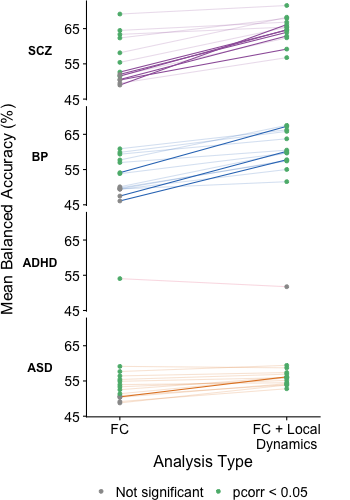

In [31]:
%%R -i all_balanced_accuracy_results,all_p_values,study_group_df,UCLA_CNP_metadata,ABIDE_metadata,pairwise_TS_feature_info -o corrected_SPI_T_res -w 350 -h 500

results_df = plyr::rbind.fill(all_balanced_accuracy_results %>%
                                filter(Analysis_Type == "Pairwise_SPI") %>%
                                left_join(all_p_values %>%
                                filter(Analysis_Type == "Pairwise_SPI") %>%
                                dplyr::select(Study:group_var, p_value_HolmBonferroni), 
                                by = join_by(group_var, Analysis_Type, Disorder, Study)), 
                              all_balanced_accuracy_results %>% 
                                filter(Analysis_Type == "Univariate_Pairwise_Combo") %>%
                                left_join(all_p_values %>%
                                filter(Analysis_Type == "Univariate_Pairwise_Combo") %>%
                                dplyr::select(Study:group_var, p_value_HolmBonferroni), 
                                by = join_by(group_var, Analysis_Type, Disorder, Study)))

corrected_SPI_T_res <- 1:nrow(study_group_df) %>%
  purrr::map_df(~ run_correctR_group(disorder = study_group_df$Disorder[.x],
                                     study = study_group_df$Study[.x],
                                     metadata = plyr::rbind.fill(UCLA_CNP_metadata, ABIDE_metadata),
                                     results_df = results_df)) %>%
  left_join(., pairwise_TS_feature_info, by=c("SPI"="pyspi_name"))

relevant_p_values <- all_p_values %>%
  filter(Analysis_Type %in% c("Pairwise_SPI", "Univariate_Pairwise_Combo")) %>%
  dplyr::rename("SPI" = group_var) %>%
  semi_join(., corrected_SPI_T_res %>% dplyr::select(SPI, Disorder), by = join_by(Disorder, SPI)) %>%
  left_join(., corrected_SPI_T_res, by = join_by(Disorder, SPI)) %>%
  mutate(Analysis_Type = ifelse(Analysis_Type == "Pairwise_SPI", "FC", "FC + Local\nDynamics"),
         individually_significant = ifelse(p_value_HolmBonferroni < 0.05, "pcorr < 0.05", "Not significant"),
         significant_diff_with_univariate = ifelse(p_value_corr_HolmBonferroni < 0.05, "Sig Diff", "No Sig Diff"),
         Analysis_Type = factor(Analysis_Type, levels=c("FC", "FC + Local\nDynamics"))) %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD"))) 

relevant_p_values %>%
  ggplot(data=., mapping=aes(x=Analysis_Type, y=100*Balanced_Accuracy_Across_Folds,
                             group = SPI)) +
  geom_line(aes(color = Disorder, 
                alpha = significant_diff_with_univariate), show.legend = FALSE) +
  scale_alpha_manual(values=c("Sig Diff" = 1, "No Sig Diff" = 0.2)) +
  scale_color_manual(values=c("Control" = "#5BB67B", 
                              "SCZ" = "#9d60a8", 
                              "BP" = "#2F77C0", 
                              "ADHD" = "#e45075", 
                              "ASD" = "#E28328")) +
  facet_wrap(Disorder ~ ., ncol=1, scales="fixed", strip.position = "left") +
  new_scale_colour() +  # start a new scale
  geom_point(aes(color = individually_significant)) +
  scale_color_manual(values = c("gray60", "#5BB67B")) +
  # scale_x_discrete(labels = wrap_format(7)) +
  xlab("Analysis Type") +
  ylab("Mean Balanced Accuracy (%)") +
  scale_y_continuous(breaks=c(45, 55, 65)) +
  scale_x_discrete(expand=c(0,0.2,0,0.2)) +
  theme(legend.position = "bottom",
        strip.placement = "outside",
        strip.background = element_blank(),
        axis.text = element_text(size=14),
        legend.text = element_text(size=14),
        axis.title = element_text(size=16),
        strip.text.y.left = element_text(angle=0, face="bold"),
        plot.margin = margin(1,30,1,1, unit="pt"),
        legend.title = element_blank())

In [32]:
%%R -i corrected_SPI_T_res

# Save corrected T-statistics to a CSV file
corrected_SPI_T_res %>%
       dplyr::select(Disorder, Figure_name, statistic, p_value_corr_HolmBonferroni) %>%
       mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD")),
              p_value_corr_HolmBonferroni = format(p_value_corr_HolmBonferroni, digits=1),
              statistic = -1*statistic) %>% # The T-statistic is stored as without versus with local dynamics, sign needs to be flipped
       arrange(Disorder, desc(statistic))  %>%
       dplyr::rename("SPI" = "Figure_name",
                     "Corrected T-statistic" = "statistic",
                     "Holm--Bonferroni p-value" = "p_value_corr_HolmBonferroni") %>%
       write.csv(., "plots/tables/Table_S8_SPI_with_vs_without_intra_regional_dynamics_corrected_T_stats.csv", row.names = F)

# Figure S1: Region-wise classification balanced accuracy is not associated with volumetric differences across clinical groups

In [33]:
# Load in the region-wise volumes data
region_wise_volumes = pd.read_feather("data/input_data/UCLA_CNP_region_wise_volumes.feather")

`geom_smooth()` using formula = 'y ~ x'


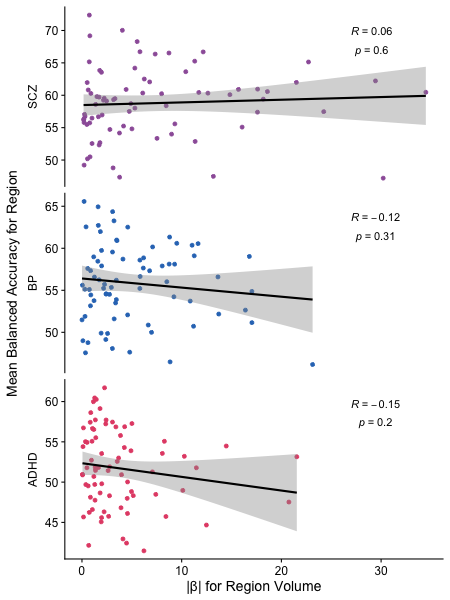

In [34]:
%%R -i region_wise_volumes,study_group_df,UCLA_CNP_metadata,all_p_values -o ROI_volume_beta_by_group -w 450 -h 600
# Visualizations

# Fit OLS models to extract beta coefficient for regional volumes in each group relative to control
run_lm_beta_stats_for_group <- function(Disorder, region_wise_volumes){
  res <- region_wise_volumes %>%
    left_join(., UCLA_CNP_metadata, by = join_by(Study, Sample_ID)) %>%
    mutate(Diagnosis = case_when(Diagnosis == "Schizophrenia" ~ "SCZ",
                                 Diagnosis == "Bipolar" ~ "BP",
                                 T ~ Diagnosis)) %>%
    filter(Diagnosis %in% c(Disorder, "Control")) %>%
    dplyr::select(Brain_Region, Diagnosis, Num_Voxels) %>%
    mutate(Diagnosis = factor(Diagnosis, levels = c("Control", Disorder))) %>%
    group_by(Brain_Region) %>%
    nest() %>%
    mutate(
      fit = map(data, ~ lm(Num_Voxels ~ Diagnosis, data = .x)),
      tidied = map(fit, tidy)
    ) %>% 
    unnest(tidied) %>%
    dplyr::select(-data, -fit) %>%
    ungroup() %>%
    filter(term != "(Intercept)") %>%
    mutate(Disorder = Disorder)
  
  return(res)
}

ROI_volume_beta_by_group <- 1:3 %>%
  purrr::map_df(~ run_lm_beta_stats_for_group(region_wise_volumes = region_wise_volumes,
                                              Disorder = study_group_df$Disorder[.x])) %>%
  group_by(Disorder) %>%
  mutate(p_value_HolmBonferroni = p.adjust(p.value, method="holm"))

# Write beta coefficients to a CSV file
ROI_volume_beta_by_group %>%
  dplyr::select(Disorder, Brain_Region, estimate, p_value_HolmBonferroni) %>%
  mutate(p_value_HolmBonferroni = format(p_value_HolmBonferroni, digits=1)) %>%
  dplyr::rename("Volume Beta Coefficient" = "estimate",
                "Brain Region" = "Brain_Region",
                "Holm--Bonferroni p-value" = "p_value_HolmBonferroni") %>%
  write.csv(., "plots/tables/Table_S9_beta_coefficients_for_brain_region_volumes.csv", row.names = F)

# Plot region-wise volume beta coefficients vs balanced accuracy
ROI_volume_beta_by_group %>%
  dplyr::select(Brain_Region, Disorder, estimate) %>%
  dplyr::rename("beta_coef" = "estimate") %>%
  left_join(., all_p_values %>% filter(Analysis_Type=="Univariate_Brain_Region") %>% dplyr::rename("Brain_Region" = "group_var"), 
            by = join_by(Brain_Region, Disorder)) %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD"))) %>%
  ggplot(data=., mapping=aes(x=abs(beta_coef), y=100*Balanced_Accuracy_Across_Folds, color=Disorder)) +
  geom_point() +
  facet_grid(Disorder ~ ., scales="free", switch="both") +
  ylab("Mean Balanced Accuracy for Region") +
  xlab("|\u03b2| for Region Volume") +
  stat_cor(method="pearson", cor.coef.name="R", color="black", label.sep = "\n", label.x = 27) +
  stat_smooth(method="lm", color="black") +
  scale_color_manual(values=c("SCZ" = "#9d60a8", 
                              "BP" = "#2f77c0", 
                              "ADHD" = "#e45075")) +
  theme(legend.position = "none",
        panel.border = element_blank(),
        strip.background = element_blank(), 
        strip.placement = "outside")

`summarise()` has grouped output by 'Diagnosis'. You can override using the
`.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


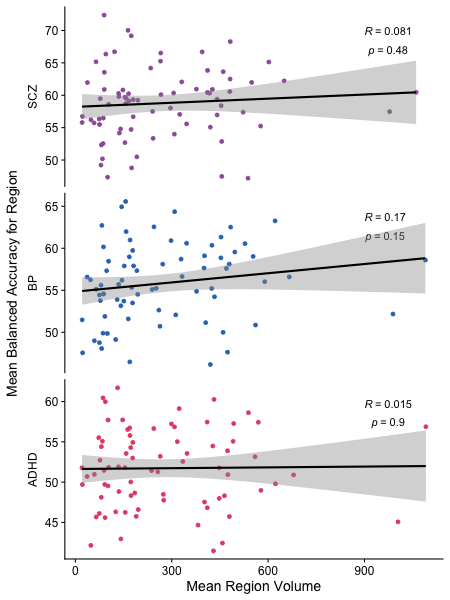

In [35]:
%%R -i region_wise_volumes,all_p_values,UCLA_CNP_metadata -w 450 -h 600

# Does the average volume of a region relate to its balanced accuracy?
region_wise_volumes %>%
  left_join(., UCLA_CNP_metadata, by = join_by(Study, Sample_ID)) %>%
  mutate(Diagnosis = case_when(Diagnosis == "Schizophrenia" ~ "SCZ",
                                Diagnosis == "Bipolar" ~ "BP",
                                T ~ Diagnosis)) %>%
  group_by(Diagnosis, Brain_Region) %>%
  summarise(mean_volume = mean(Num_Voxels)) %>%
  filter(Diagnosis != "Control") %>%
  dplyr::rename("Disorder"="Diagnosis") %>%
  left_join(., all_p_values %>% filter(Analysis_Type=="Univariate_Brain_Region") %>% dplyr::rename("Brain_Region" = "group_var"), by = join_by(Disorder, Brain_Region)) %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD"))) %>%
  ggplot(data=., mapping=aes(x=mean_volume, y=100*Balanced_Accuracy_Across_Folds, color=Disorder)) +
  geom_point() +
  facet_grid(Disorder ~ ., scales="free", switch="both") +
  ylab("Mean Balanced Accuracy for Region") +
  xlab("Mean Region Volume") +
  stat_cor(color="black", label.sep = "\n", label.x = 900) +
  stat_smooth(method="lm", color="black") +
  scale_color_manual(values=c("SCZ" = "#9d60a8", 
                            "BP" = "#2f77c0", 
                            "ADHD" = "#e45075")) +
  theme(legend.position = "none",
        panel.border = element_blank(),
        strip.background = element_blank(),
        strip.placement = "outside")

# Figure S2: Comparing classification performance with versus without inverse probability weighting.

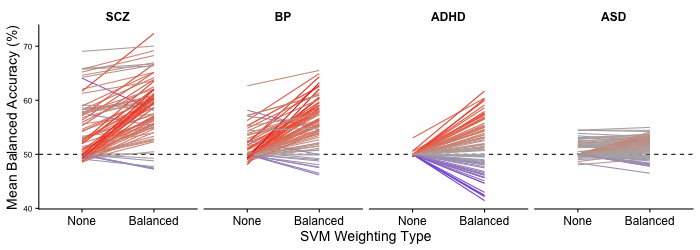

In [36]:
%%R -i balanced_accuracy_with_vs_without_inv_prob_weighting -w 700 -h 250

# For each brain region, compare the difference in mean balanced accuracy with versus without inverse probability weighting
balanced_accuracy_with_vs_without_inv_prob_weighting %>%
  filter(Analysis_Type=="Brain_Region") %>%
  mutate(Disorder = case_when(Disorder=="Schizophrenia" ~ "SCZ",
                                      Disorder=="Bipolar" ~ "BP",
                                      T ~ Disorder)) %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD")),
         Weighting_Type = factor(Weighting_Type, levels=c("None", "Balanced"))) %>%
  group_by(Disorder, Analysis_Type, group_var, Weighting_Type) %>%
  summarise(Mean_Balanced_Accuracy = mean(Balanced_Accuracy), .groups="keep") %>%
  group_by(Disorder, Analysis_Type, group_var) %>%
  mutate(Weighting_Diff = Mean_Balanced_Accuracy[Weighting_Type=="Balanced"] - Mean_Balanced_Accuracy[Weighting_Type=="None"]) %>%
  ungroup() %>%
  ggplot(data=., mapping=aes(x=Weighting_Type, y=100*Mean_Balanced_Accuracy, group=group_var, color=Weighting_Diff)) +
  geom_hline(yintercept = 50, linetype=2) +
  geom_line() +
  xlab("SVM Weighting Type") +
  ylab("Mean Balanced Accuracy (%)") +
  scale_color_gradient2(low="blue", mid="gray70", high="red", midpoint = 0) +
  facet_grid(. ~ Disorder, scales="free", space="free") +
  theme(legend.position = "none",
        axis.text.y = element_text(size=8),
        strip.text.x = element_text(angle=0, face="bold"),
        strip.background = element_blank())

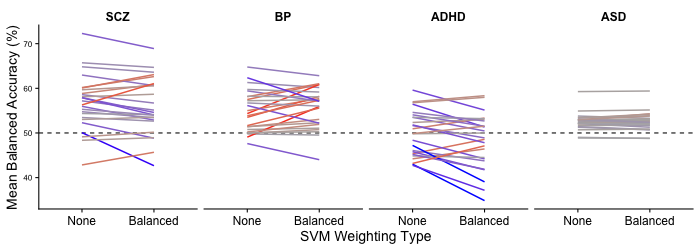

In [37]:
%%R -i balanced_accuracy_with_vs_without_inv_prob_weighting -w 700 -h 250

# For each time-series feature, compare the difference in mean balanced accuracy with versus without inverse probability weighting
balanced_accuracy_with_vs_without_inv_prob_weighting %>%
  filter(Analysis_Type=="TS_Feature") %>%
  mutate(Disorder = case_when(Disorder=="Schizophrenia" ~ "SCZ",
                                      Disorder=="Bipolar" ~ "BP",
                                      T ~ Disorder)) %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD")),
         Weighting_Type = factor(Weighting_Type, levels=c("None", "Balanced"))) %>%
  group_by(Disorder, Analysis_Type, group_var, Weighting_Type) %>%
  summarise(Mean_Balanced_Accuracy = mean(Balanced_Accuracy), .groups="keep") %>%
  group_by(Disorder, Analysis_Type, group_var) %>%
  mutate(Weighting_Diff = Mean_Balanced_Accuracy[Weighting_Type=="Balanced"] - Mean_Balanced_Accuracy[Weighting_Type=="None"]) %>%
  ungroup() %>%
  ggplot(data=., mapping=aes(x=Weighting_Type, y=100*Mean_Balanced_Accuracy, group=group_var, color=Weighting_Diff)) +
  geom_hline(yintercept = 50, linetype=2) +
  geom_line(linewidth=0.7) +
  xlab("SVM Weighting Type") +
  ylab("Mean Balanced Accuracy (%)") +
  scale_color_gradient2(low="blue", mid="gray70", high="red", midpoint = 0) +
  facet_grid(. ~ Disorder, scales="free", space="free") +
  theme(legend.position = "none",
        axis.text.y = element_text(size=8),
        strip.text.x = element_text(angle=0, face="bold"),
        strip.background = element_blank())

# Figure S3. Evaluating dimensionality reduction for univariate region $\times$ feature combination classifiers ($\mathrm{A_{uni\_combo}}$)

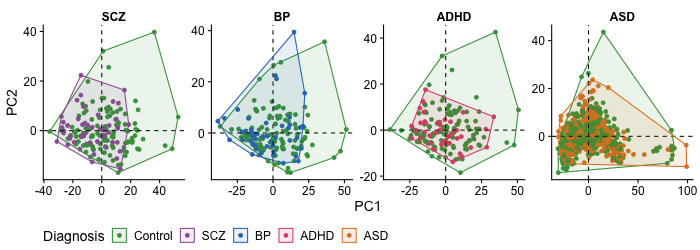

In [38]:
%%R -i univariate_combo_first25_PCs -w 700 -h 250
univariate_combo_first25_PCs %>%
  mutate(Disorder = case_when(Disorder == "Schizophrenia" ~ "SCZ",
                                      Disorder == "Bipolar" ~ "BP",
                                      T ~ Disorder),
        Diagnosis = case_when(Diagnosis == "Schizophrenia" ~ "SCZ",
                                      Diagnosis == "Bipolar" ~ "BP",
                                      T ~ Diagnosis)) %>%
  mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD")),
         Diagnosis = factor(Diagnosis, levels = c("Control", "SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=`Dim.1`, y=`Dim.2`, color=Diagnosis)) +
  geom_point() +
  geom_vline(xintercept = 0, linetype=2) +
  geom_hline(yintercept = 0, linetype=2) +
  stat_chull(aes(color = Diagnosis, fill = Diagnosis), 
             alpha = 0.1, geom = "polygon")+
  ylab("PC2") +
  xlab("PC1") +
  facet_wrap(Disorder ~ ., scales="free", nrow=1) +
  scale_fill_manual(values = c("SCZ"="#9d60a8", 
                                "BP"="#2F77C0", 
                                "ADHD"="#e45075",
                                "ASD" = "#E28328",
                                "Control" = "#439E47")) +
  scale_color_manual(values = c("SCZ"="#9d60a8", 
                                "BP"="#2F77C0", 
                                "ADHD"="#e45075",
                                "ASD" = "#E28328",
                                "Control" = "#439E47")) +
  theme(legend.position = "bottom",
        strip.text = element_text(face="bold"),
        strip.background = element_blank())

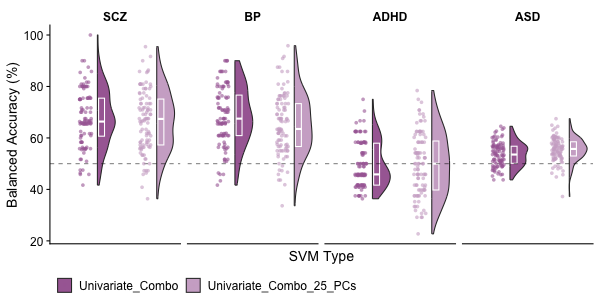

In [39]:
%%R -i univariate_combo_first25_PCs_balanced_accuracy,all_balanced_accuracy_results,study_group_df -w 600 -h 300
# Comparing classification performance using the first 25 PCs per disorder

univariate_combo_first25_PCs_balanced_accuracy %>%
  mutate(Disorder = case_when(Disorder == "Schizophrenia" ~ "SCZ",
                                      Disorder == "Bipolar" ~ "BP",
                                      T ~ Disorder)) %>%
  plyr::rbind.fill(all_balanced_accuracy_results %>% filter(Analysis_Type=="Univariate_Combo")) %>%
  left_join(study_group_df, by = join_by(Study, Disorder)) %>%
  mutate(Disorder = factor(Disorder, levels=c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Analysis_Type, y=100*Balanced_Accuracy)) +
  xlab("SVM Type") +
  ylab("Balanced Accuracy (%)") +
  geom_violinhalf(aes(fill = Analysis_Type), 
                  position = position_nudge(x=0.2),
                  scale="width", width=0.6)  +
  geom_boxplot(width=0.1, notch=FALSE, notchwidth = 0.4, outlier.shape = NA,
               fill=NA, color="white",
               position = position_nudge(x=0.27), coef = 0) +
  geom_hline(yintercept = 50, linetype=2, alpha=0.5) +
  facet_grid(. ~ Disorder) +
  geom_point(aes(color = Analysis_Type), position = position_jitter(width=0.1),
             size = 1.75, alpha=0.6, stroke=0) +
  labs(fill="", color="") +
  scale_fill_manual(values = c("#a86ba3", "#cfafcd")) +
  scale_color_manual(values = c("#a86ba3", "#cfafcd")) +
  theme(legend.position = "bottom",
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        strip.text = element_text(face="bold"),
        strip.background = element_blank())

`summarise()` has grouped output by 'Study', 'Disorder'. You can override using
the `.groups` argument.


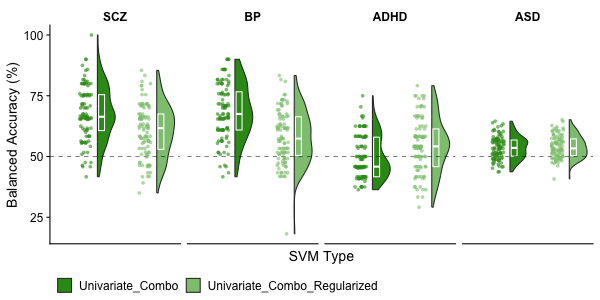

In [40]:
%%R -i all_L1_regularized_balanced_accuracy_results,study_group_df,all_balanced_accuracy_results -w 600 -h 300

# L1-regularized SVM comparison

# Aggregate balanced accuracy by repeats
SVM_L1_balanced_accuracy <- all_L1_regularized_balanced_accuracy_results %>%
  group_by(Study, Disorder, Analysis_Type) %>%
  summarise(Balanced_Accuracy_Across_Folds = mean(Balanced_Accuracy, na.rm=T),
            Balanced_Accuracy_Across_Folds_SD = sd(Balanced_Accuracy, na.rm=T)) 

# Plot performance in normal SVM vs. L1-regularized SVM
all_L1_regularized_balanced_accuracy_results %>%
  plyr::rbind.fill(all_balanced_accuracy_results %>% filter(Analysis_Type=="Univariate_Combo")) %>%
  left_join(study_group_df, by = join_by(Study, Disorder)) %>%
  mutate(Disorder = factor(Disorder, levels=c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Analysis_Type, y=100*Balanced_Accuracy)) +
  xlab("SVM Type") +
  ylab("Balanced Accuracy (%)") +
  geom_violinhalf(aes(fill = Analysis_Type), 
                  position = position_nudge(x=0.2),
                  scale="width", width=0.6)  +
  geom_boxplot(width=0.1, notch=FALSE, notchwidth = 0.4, outlier.shape = NA,
               fill=NA, color="white",
               position = position_nudge(x=0.27), coef = 0) +
  geom_hline(yintercept = 50, linetype=2, alpha=0.5) +
  facet_grid(. ~ Disorder) +
  geom_point(aes(color = Analysis_Type), position = position_jitter(width=0.1),
             size = 1.75, alpha=0.6, stroke=0) +
  labs(fill="", color="") +
  scale_fill_manual(values = c("#319719", "#8dc57f")) +
  scale_color_manual(values = c("#319719", "#8dc57f")) +
  theme(legend.position = "bottom",
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        strip.text = element_text(face="bold"),
        strip.background = element_blank())

# Figure S4: Most patients show greater head movement in the scanner, which can distinguish them from controls

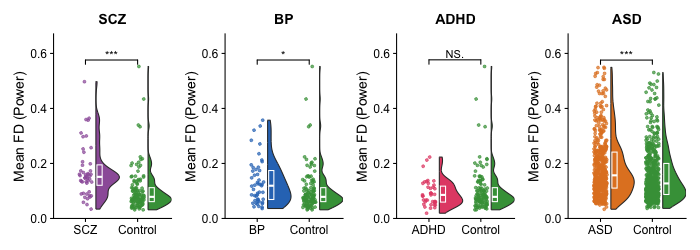

In [41]:
%%R -i UCLA_CNP_metadata,ABIDE_metadata,UCLA_CNP_subjects_to_keep,ABIDE_subjects_to_keep -o UCLA_CNP_mean_FD,ABIDE_mean_FD,FD_dataset -w 700 -h 250

# Load head movement data
UCLA_CNP_mean_FD <- read.table("data/movement_data/UCLA_CNP_Mean_FD_Power.txt", 
                                       sep=",", colClasses = "character", header=T)
ABIDE_mean_FD <- read.table("data/movement_data/ABIDE_Mean_FD_Power.txt",
                                     sep=",", colClasses = "character", header=T)

# Set mFD columns as numeric
UCLA_CNP_mean_FD <- UCLA_CNP_mean_FD %>%
  mutate(Mean_FD_Power = as.numeric(Mean_FD_Power)) %>%
  left_join(., UCLA_CNP_metadata, by="Sample_ID") %>%
  filter(Sample_ID %in% UCLA_CNP_subjects_to_keep$Sample_ID)

ABIDE_mean_FD <- ABIDE_mean_FD %>%
  mutate(Mean_FD_Power = as.numeric(Mean_FD_Power)) %>%
  left_join(., ABIDE_metadata, by = join_by(Sample_ID)) %>%
  filter(Sample_ID %in% ABIDE_subjects_to_keep$Sample_ID) 

control_color <- "#439E47"
group_colors <- c("#9d60a8", "#2F77C0", "#e45075","#E28328")

# Find ymin and ymax
FD_dataset = plyr::rbind.fill(UCLA_CNP_mean_FD, ABIDE_mean_FD) %>%
  mutate(Diagnosis = case_when(Diagnosis=="Schizophrenia" ~ "SCZ",
                                      Diagnosis=="Bipolar" ~ "BP",
                                      T ~ Diagnosis))

ymin <- 0
ymax <- max(FD_dataset$Mean_FD_Power)

plots <- 1:4 %>%
  purrr::map(~ plot_group_vs_control_mean_FD(FD_dataset = FD_dataset,
                                     study = study_group_df$Study[.x],
                                     dx = study_group_df$Disorder[.x],
                                     dx_title = study_group_df$Disorder[.x],
                                     ymin = ymin,
                                     ymax = 0.61,
                                     group_color = group_colors[.x]))

wrap_plots(plots, nrow=1)

# Figure S5: Head movement in the scanner is associated with whole-brain and regional BOLD SD in some disorders

`geom_smooth()` using formula = 'y ~ x'


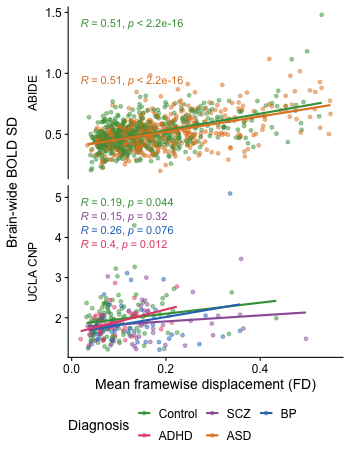

In [46]:
%%R -i UCLA_CNP_intra_regional_feature_data,ABIDE_intra_regional_feature_data,UCLA_CNP_mean_FD,ABIDE_mean_FD,UCLA_CNP_metadata,ABIDE_metadata -o SD_brain_wide_avg -w 350 -h 450
# Plot brain-wide average SD vs head movement
SD_brain_wide_avg <- UCLA_CNP_intra_regional_feature_data %>%
  plyr::rbind.fill(., ABIDE_intra_regional_feature_data) %>%
  filter(names == "DN_Spread_Std") %>%
  group_by(Sample_ID) %>%
  summarise(meanval = mean(values, na.rm=T)) %>%
  left_join(., plyr::rbind.fill(UCLA_CNP_mean_FD, ABIDE_mean_FD), by = join_by(Sample_ID)) %>%
  left_join(., plyr::rbind.fill(UCLA_CNP_metadata, ABIDE_metadata), by = join_by(Sample_ID, Study, Age, Diagnosis, Site, Sex)) %>%
  mutate(Study = ifelse(Study == "UCLA_CNP", "UCLA CNP", "ABIDE"))  %>%
  mutate(Diagnosis = case_when(Diagnosis == "Schizophrenia" ~ "SCZ",
                               Diagnosis == "Bipolar" ~ "BP",
                               T ~ Diagnosis))


SD_brain_wide_avg %>%
  mutate(Diagnosis = factor(Diagnosis, levels = c("Control", "SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Mean_FD_Power, y=meanval, color=Diagnosis)) +
  geom_point(alpha=0.5) +
  facet_grid(Study ~ ., scale="free", switch="both") +
  ylab("Brain-wide BOLD SD") +
  xlab("Mean framewise displacement (FD)") +
  scale_color_manual(values = c("Control" = "#439E47", 
                                "SCZ" = "#9d60a8", 
                                "BP" = "#2F77C0", 
                                "ADHD" = "#e45075", 
                                "ASD" = "#E28328")) +
  stat_smooth(method="lm", se=F) +
  theme(strip.background = element_blank(),
        legend.position="bottom",
        strip.placement="outside") +
  stat_cor(show.legend = FALSE) +
  guides(color=guide_legend(nrow=2,byrow=TRUE))

In [47]:
%%R -i SD_brain_wide_avg -o SD_brain_wide_avg_corrs

# # Calculate correlations
SD_brain_wide_avg_corrs <- SD_brain_wide_avg %>%
  mutate(Sample_ID = as.character(Sample_ID)) %>%
  group_by(Study, Diagnosis) %>%
  nest() %>%
  mutate(
    test = map(data, ~ cor.test(.x$meanval, .x$Mean_FD_Power)), # S3 list-col
    tidied = map(test, tidy)
  ) %>%
  unnest(tidied) %>%
  dplyr::select(-data, -test) %>%
  ungroup() %>%
  mutate(p_value_HolmBonferroni = p.adjust(p.value, method="holm")) 

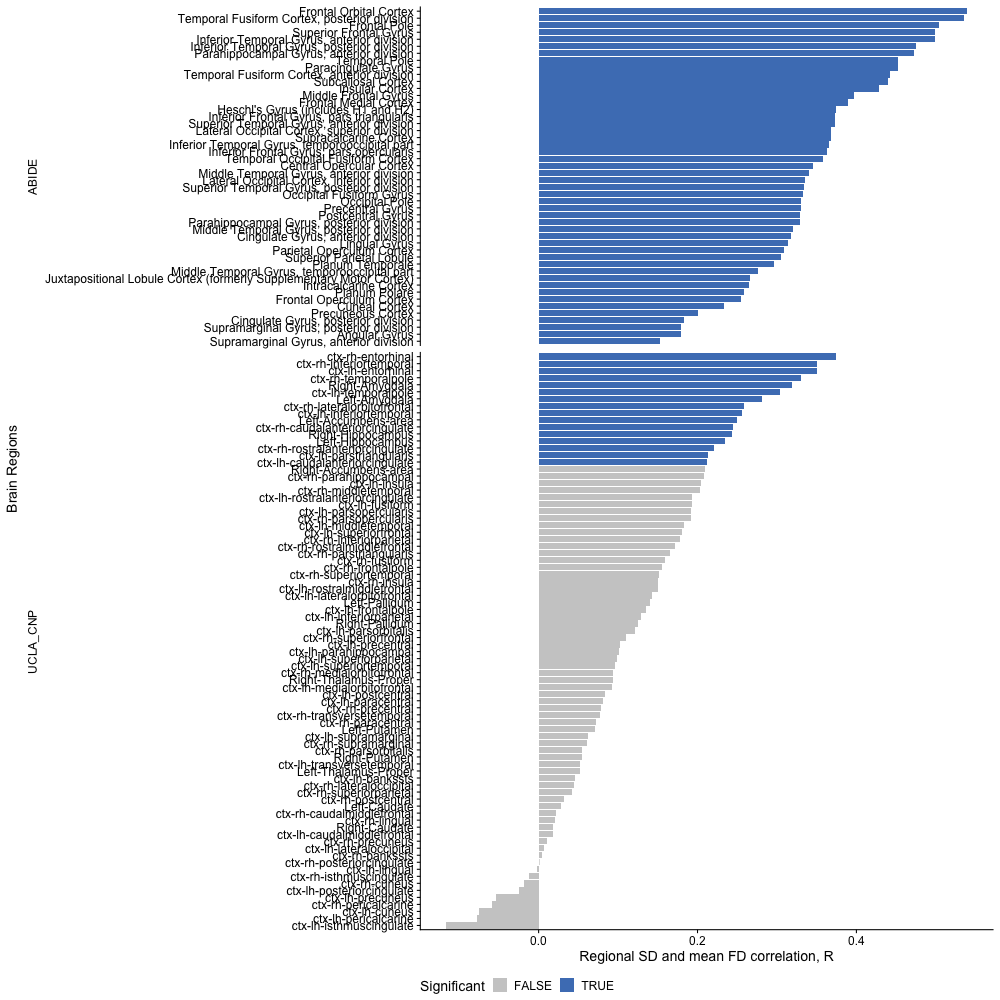

In [48]:
%%R -i UCLA_CNP_intra_regional_feature_data,ABIDE_intra_regional_feature_data,UCLA_CNP_metadata,ABIDE_metadata,UCLA_CNP_mean_FD,ABIDE_mean_FD -o head_motion_SD_corr_regional -w 1000 -h 1000

# Compare region-specific SD values with whole-brain head movement

# Calculate correlations
head_motion_SD_corr_regional <- UCLA_CNP_intra_regional_feature_data %>%
  plyr::rbind.fill(., ABIDE_intra_regional_feature_data) %>%
  filter(names == "DN_Spread_Std") %>%
  left_join(., plyr::rbind.fill(UCLA_CNP_mean_FD, ABIDE_mean_FD), by = join_by(Sample_ID, Diagnosis, Age, Sex, Study, Site)) %>%
  left_join(., plyr::rbind.fill(UCLA_CNP_metadata, ABIDE_metadata), by = join_by(Sample_ID, Diagnosis, Age, Sex, Study, Site)) %>%
  group_by(Study, Brain_Region) %>%
  nest() %>%
  mutate(
    test = map(data, ~ cor.test(.x$values, .x$Mean_FD_Power)), # S3 list-col
    tidied = map(test, tidy)
  ) %>%
  unnest(tidied) %>%
  select(-data, -test) %>%
  group_by(Study) %>%
  mutate(p_HolmBonferroni = p.adjust(p.value, method="holm")) %>%
  arrange(desc(abs(estimate)))

# Plot regional SD correlations by brain region within the brain
head_motion_SD_corr_regional %>%
  mutate(Brain_Region = fct_reorder(Brain_Region, estimate)) %>%
  ggplot(data=., mapping=aes(x=Brain_Region,
                             y=estimate,
                             fill=p_HolmBonferroni<0.05)) +
  geom_bar(stat="identity") +
  facet_grid(Study ~ ., scales="free", switch="both",
             space="free") +
  coord_flip() +
  scale_fill_manual(values=list("TRUE"="#4C7FC0",
                                "FALSE"="gray80")) +
  labs(fill = "Significant") +
  xlab("Brain Regions") +
  ylab("Regional SD and mean FD correlation, R") +
  theme(strip.background = element_blank(),
        legend.position="bottom",
        strip.placement="outside")

# Figure S6: Null balanced accuracy metrics are approximately normally distributed across brain regions in all clinical cohorts.

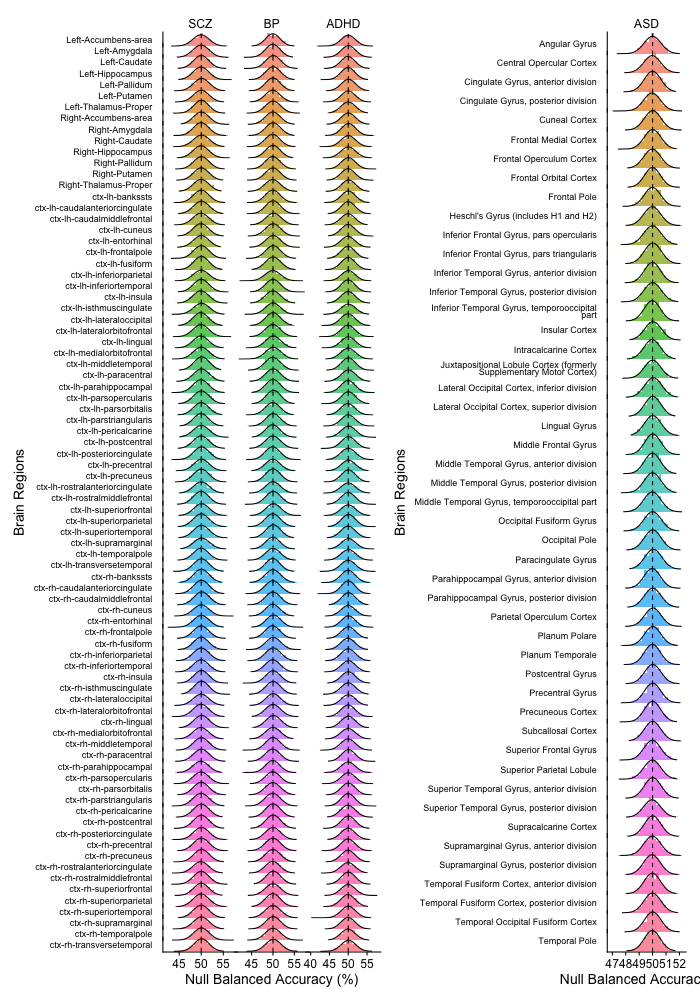

In [49]:
%%R -i all_null_distributions,study_group_df -w 700 -h 1000

intra_regional_nulls_brain_regions <- all_null_distributions %>% filter(Analysis_Type == "Univariate_Brain_Region") %>%
  mutate(Null_Balanced_Accuracy = 100*Null_Balanced_Accuracy) %>%
  group_by(Analysis_Type, Disorder, Study, group_var) %>%
  mutate(mu = mean(Null_Balanced_Accuracy),
         sigma = sd(Null_Balanced_Accuracy))

# Plot in one ridgeline plot
UCLA_CNP_summary_curves <- intra_regional_nulls_brain_regions %>%
  filter(Study=="UCLA_CNP") %>%
  left_join(., study_group_df, by = join_by(Disorder, Study)) %>%
  group_by(group_var, Disorder) %>%
  mutate(Disorder = factor(Disorder, levels=c("SCZ", "BP", "ADHD"))) %>%
  reframe(x = Null_Balanced_Accuracy,
          y = dnorm(Null_Balanced_Accuracy, 
                    mean = mean(Null_Balanced_Accuracy),
                    sd = sd(Null_Balanced_Accuracy)))

UCLA_CNP_univariate_null_plot <- intra_regional_nulls_brain_regions %>%
  left_join(., study_group_df, by = join_by(Disorder, Study)) %>%
  filter(Study=="UCLA_CNP") %>%
  mutate(Disorder = factor(Disorder, levels=c("SCZ", "BP", "ADHD"))) %>%
  ggplot(data=., mapping=aes(fill = group_var, x=Null_Balanced_Accuracy)) +
  geom_histogram(aes(y = after_stat(density)), alpha=0.7, bins=30) +
  facet_grid(group_var~Disorder, scales="free", switch="y") +
  xlab("Null Balanced Accuracy (%)") +
  ylab("Brain Regions") +
  geom_line(data=UCLA_CNP_summary_curves, aes(x=x, y=y), color="black") +
  geom_vline(xintercept = 50, linetype=2) +
  theme(legend.position="none",
        strip.text.y.left = element_text(angle=0, size=9, lineheight = 0.6, hjust=1),
        strip.background = element_blank(),
        strip.placement="outside",
        panel.spacing = unit(-0.25, "lines"),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank()) 

# Calculate the normal curve density for each group
ABIDE_summary_curves <- intra_regional_nulls_brain_regions %>%
  filter(Study=="ABIDE") %>%
  left_join(., study_group_df, by = join_by(Disorder, Study)) %>%
  group_by(group_var) %>%
  reframe(x = Null_Balanced_Accuracy,
          y = dnorm(Null_Balanced_Accuracy, 
                    mean = mean(Null_Balanced_Accuracy),
                    sd = sd(Null_Balanced_Accuracy)))

ABIDE_univariate_null_plot <- intra_regional_nulls_brain_regions %>%
  filter(Study=="ABIDE") %>%
  left_join(., study_group_df, by = join_by(Disorder, Study)) %>%
  ggplot(data=., mapping=aes(fill = group_var, x=Null_Balanced_Accuracy)) +
  geom_histogram(aes(y = after_stat(density)), alpha=0.7, bins=30) +
  facet_grid(group_var~Disorder, scales="free", switch="y",
             labeller = labeller(group_var = label_wrap_gen(45))) +
  xlab("Null Balanced Accuracy (%)") +
  ylab("Brain Regions") +
  geom_line(data=ABIDE_summary_curves, aes(x=x, y=y), color="black") +
  geom_vline(xintercept = 50, linetype=2) +
  theme(legend.position="none",
        strip.text.y.left = element_text(angle=0, size=9, lineheight = 0.6, hjust=1),
        strip.background = element_blank(),
        strip.placement="outside",
        panel.spacing = unit(-0.25, "lines"),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank()) 

wrap_plots(list(UCLA_CNP_univariate_null_plot, ABIDE_univariate_null_plot), widths = c(0.7, 0.253))


# Figure S7: Participants are allocated into the same set of folds and repeats across models to enable direct comparison of performance across models

In [50]:
%%R -i all_fold_assignments,UCLA_CNP_metadata,ABIDE_metadata

all_fold_assignments %>%
       filter(Analysis_Type=="Univariate_Brain_Region") %>%
       left_join(., plyr::rbind.fill(UCLA_CNP_metadata, ABIDE_metadata), by = join_by(Sample_ID, Study)) %>%
       group_by(Disorder, Study) %>%
       mutate(num_samples = length(unique(Sample_ID))) %>%
       group_by(Study, Disorder, group_var, Repeat) %>%
       mutate(Control_Prop = 100*sum(Diagnosis == "Control")/num_samples) %>%
       group_by(Study, Disorder, group_var, Fold, Repeat, Control_Prop) %>%
       summarise(num_subjects_in_test_fold = n(),
              num_controls_in_test_fold = sum(Diagnosis == "Control"),
              control_prop_in_fold = 100*num_controls_in_test_fold/num_subjects_in_test_fold,
              .groups="keep") %>%
       group_by(Study, Disorder, Control_Prop) %>%
       summarise(mean_control_prop_across_folds = mean(control_prop_in_fold),
              min_control_prop_across_folds = min(control_prop_in_fold),
              max_control_prop_across_folds = max(control_prop_in_fold),
              SD_control_prop_across_folds = sd(control_prop_in_fold))


`summarise()` has grouped output by 'Study', 'Disorder'. You can override using
the `.groups` argument.
# A tibble: 4 × 7
# Groups:   Study, Disorder [4]
  Study    Disorder Control_Prop mean_control_prop_acro…¹ min_control_prop_acr…²
  <chr>    <chr>           <dbl>                    <dbl>                  <dbl>
1 ABIDE    ASD              53.0                     53.0                   52.3
2 UCLA_CNP ADHD             74.8                     74.8                   73.3
3 UCLA_CNP BP               70.3                     70.3                   68.8
4 UCLA_CNP SCZ              70.7                     70.7                   68.8
# ℹ abbreviated names: ¹​mean_control_prop_across_folds,
#   ²​min_control_prop_across_folds
# ℹ 2 more variables: max_control_prop_across_folds <dbl>,
#   SD_control_prop_across_folds <dbl>


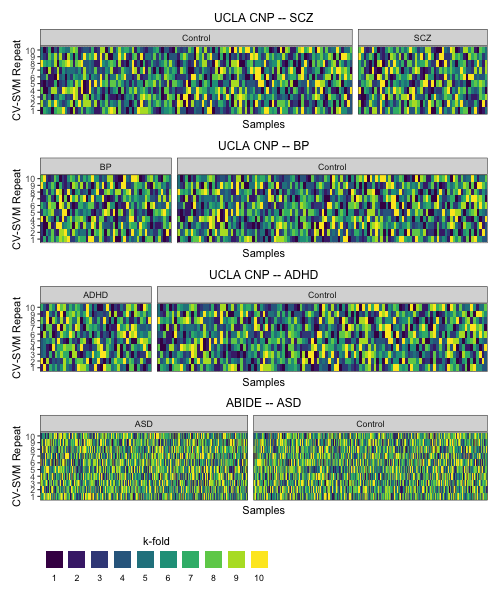

In [51]:
%%R -i all_fold_assignments,UCLA_CNP_metadata,ABIDE_metadata -w 500 -h 600

# UCLA CNP schizophrenia vs. control ctx-lh-caudalanteriorcingulate
UCLA_scz_heatmap <- all_fold_assignments %>%
  filter(Study == "UCLA_CNP", Disorder  == "SCZ", Analysis_Type=="Univariate_Brain_Region") %>%
  left_join(., UCLA_CNP_metadata, by = join_by(Sample_ID, Study)) %>%
  plot_fold_heatmap_for_dataset(fold_assignments_df = .,
                           group_var_to_use = "ctx-lh-caudalanteriorcingulate",
                           plot_title = "UCLA CNP -- SCZ")


# UCLA CNP ADHD vs. control ctx-lh-caudalanteriorcingulate
UCLA_ADHD_heatmap <- all_fold_assignments %>%
  filter(Study == "UCLA_CNP", Disorder  == "ADHD", Analysis_Type=="Univariate_Brain_Region") %>%
  left_join(., UCLA_CNP_metadata, by = join_by(Sample_ID, Study)) %>%
  plot_fold_heatmap_for_dataset(fold_assignments_df = .,
                           group_var_to_use = "ctx-lh-caudalanteriorcingulate",
                           plot_title = "UCLA CNP -- ADHD")


# UCLA CNP ADHD vs. control ctx-lh-caudalanteriorcingulate
UCLA_bipolar_heatmap <- all_fold_assignments %>%
  filter(Study == "UCLA_CNP", Disorder  == "BP", Analysis_Type=="Univariate_Brain_Region") %>%
  left_join(., UCLA_CNP_metadata, by = join_by(Sample_ID, Study)) %>%
  plot_fold_heatmap_for_dataset(fold_assignments_df = .,
                           group_var_to_use = "ctx-lh-caudalanteriorcingulate",
                           plot_title = "UCLA CNP -- BP")


# Use ABIDE ASD vs. control Superior Frontal Gyrus as example
ABIDE_ASD_heatmap <- all_fold_assignments %>%
  filter(Study == "ABIDE", Disorder  == "ASD", Analysis_Type=="Univariate_Brain_Region") %>%
  left_join(., ABIDE_metadata, by = join_by(Sample_ID, Study)) %>%
  plot_fold_heatmap_for_dataset(fold_assignments_df = .,
                           group_var_to_use = "Superior Frontal Gyrus",
                           plot_title = "ABIDE -- ASD")

wrap_plots(list(UCLA_scz_heatmap,
                UCLA_bipolar_heatmap,
                UCLA_ADHD_heatmap,
                ABIDE_ASD_heatmap),
           ncol = 1) + 
  plot_layout(guides = "collect") & theme(legend.position = 'bottom',
                                          plot.title = element_text(size=12))

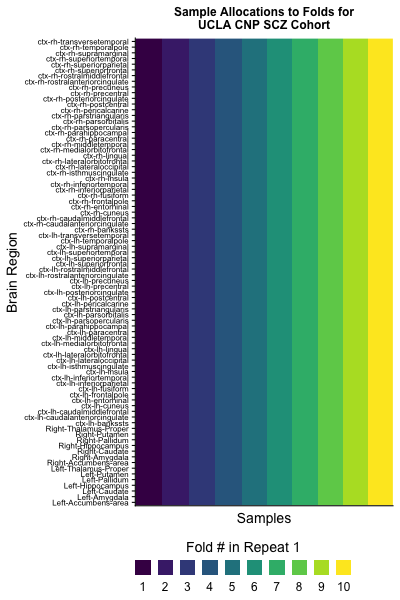

In [52]:
%%R -i all_fold_assignments -w 400 -h 600

# Heatmap for all 82 brain regions in the UCLA schizophrenia vs control dataset 
# to show that samples are allocated in the same way across regions within repeat 1
all_fold_assignments %>%
  filter(Study == "UCLA_CNP", Disorder == "SCZ",
         Analysis_Type == "Univariate_Brain_Region", Repeat == 1) %>%
  mutate(Fold = factor(Fold))  %>%
  ggplot(data = ., mapping = aes(x=fct_reorder(Sample_ID, as.numeric(Fold)), y = group_var, fill = Fold)) +
  geom_raster() +
  scale_fill_viridis_d() +
  ylab("Brain Region") +
  labs(fill = "Fold # in Repeat 1") +
  ggtitle("Sample Allocations to Folds for\nUCLA CNP SCZ Cohort") +
  xlab("Samples") +
  theme(legend.position="bottom",
        plot.title = element_text(hjust=0.5, size=12),
        axis.text.y = element_text(size=8),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank()) +
  guides(fill = guide_legend(title.position = "top", 
                             nrow = 1,
                             title.hjust = 0.5,
                             label.position = "bottom")) 

# Figure S8: Comparing normalization methods supports the use of the outlier-robust mixed sigmoid method

In [53]:
normalization_binned_data = pd.read_feather("data/feature_info/all_normalisations_counts.feather")

First we'll create histograms for each univariate (intra-regional) time-series feature with (1) raw values, (2) z-scored values, and (3) values scaled with the outlier-robust sigmoidal transformation for the two studies.

In addition: There were 50 or more warnings (use warnings() to see the first 50)


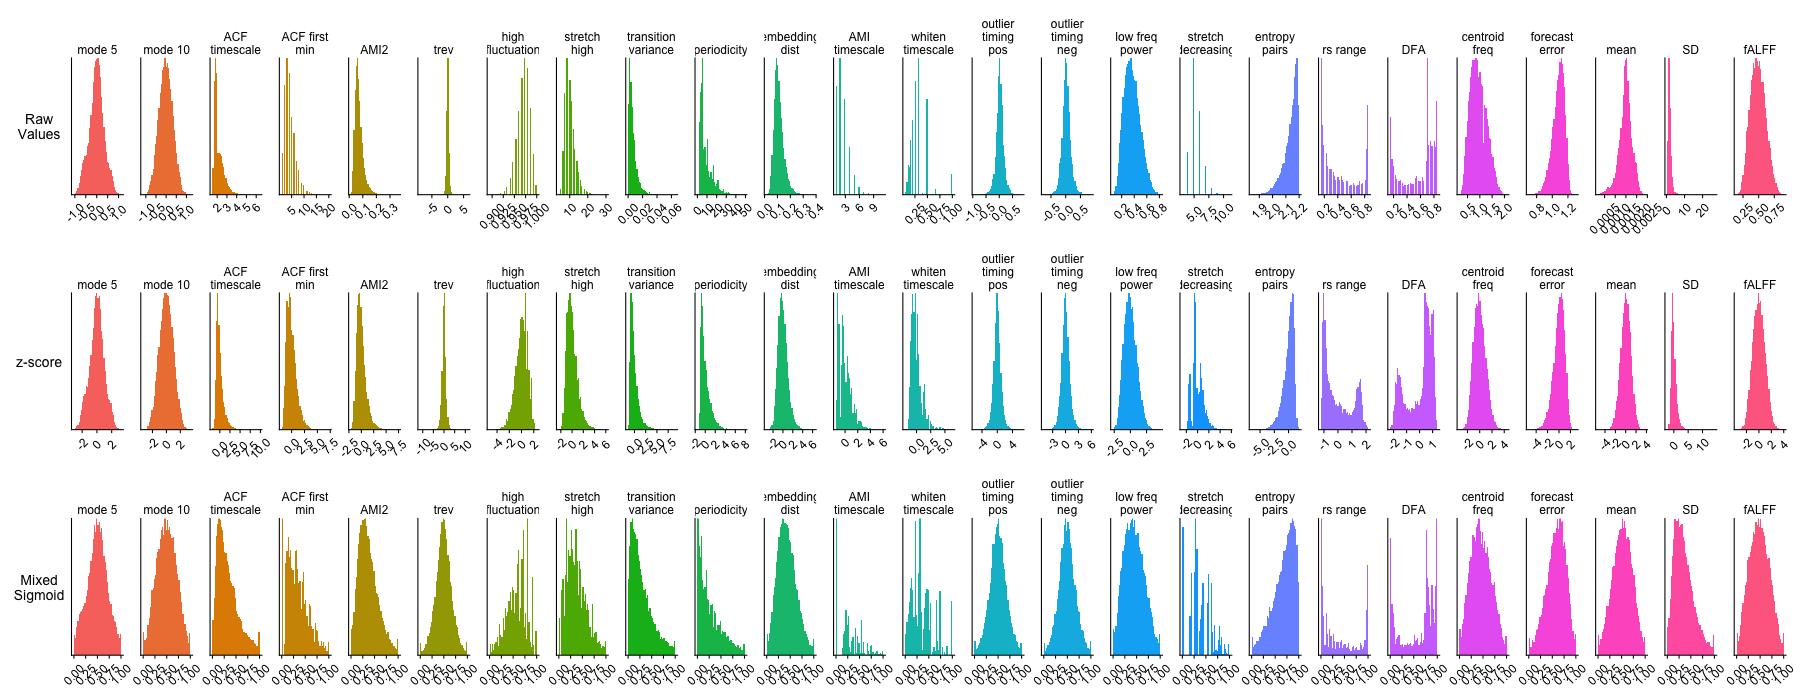

In [54]:
%%R -i normalization_binned_data,univariate_TS_feature_info -w 1800 -h 700 -o count_data_for_ggplot_univariate,feature_list,color_list,gg_color_hue

# Tabulate the normalized counts for all univariate time-series features by normalization method
count_data_for_ggplot_univariate <- normalization_binned_data %>%
  filter(names %in% univariate_TS_feature_info$feature_name) %>%
  mutate(bin = gsub("\\[|\\]", "", bin)) %>%
  separate(bin, into=c("lower","upper"), sep=", ") %>%
  rowwise() %>%
  mutate(bin_center = mean(c(as.numeric(lower), as.numeric(upper))), 
         .keep = "unused") %>%
  group_by(names, Normalisation, Study) %>%
  mutate(max_count = max(count)) %>%
  rowwise() %>%
  mutate(count_normalised = count/max_count) 

# Helper function to emulate the default ggplot color palette
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

# Store a list of the feature names and their corresponding ggplot color
feature_list <- unique(count_data_for_ggplot_univariate$names)
color_list <- gg_color_hue(length(feature_list))

# Iterate over each feature and make one histogram per normalization method

UCLA_plot_list <- list()

for (i in 1:25) {
  feature <- feature_list[i]
  
  for (norm in c("Raw_Values", "z-score", "MixedSigmoid")) {
    binwidth_feature <- count_data_for_ggplot_univariate %>%
      filter(names==feature, Normalisation==norm, Study=="UCLA_CNP") %>%
      group_by(names, Normalisation, Study) %>%
      summarise(data_range = max(bin_center) - min(bin_center), .groups="keep")
    
    p_UCLA_CNP <- count_data_for_ggplot_univariate %>%
      filter(names==feature, Study=="UCLA_CNP", Normalisation==norm) %>%
      left_join(., univariate_TS_feature_info, by=c("names" = "feature_name")) %>%
      mutate(Figure_name = gsub("_", " ", Figure_name)) %>%
      ggplot(data=., mapping=aes(x=bin_center,
                                 y=count_normalised,
                                 fill=names)) +
      geom_bar(stat="identity", width=0.026*binwidth_feature$data_range,
               fill = color_list[i]) +
      facet_wrap(. ~ Figure_name, scales="free",
                 labeller = labeller(Figure_name = label_wrap_gen(10))) +
      theme(legend.position = "none",
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            axis.title.y = element_text(angle=0, vjust=0.5),
            axis.text.x = element_text(angle=45, vjust=0.5),
            axis.title.x = element_blank(),
            strip.background = element_blank()) + 
      scale_y_continuous(expand = c(0, 0)) 
    
    if (i == 1) {
      p_UCLA_CNP <- p_UCLA_CNP  +
        ylab(ifelse(norm=="MixedSigmoid", "Mixed\nSigmoid", gsub("_", "\n", norm))) 
    } else {
      p_UCLA_CNP <- p_UCLA_CNP +
        theme(axis.title.y = element_blank())
    }
    
    UCLA_plot_list <- list.append(UCLA_plot_list, p_UCLA_CNP)
  }
}

# Wrap UCLA CNP plots
wrapped_UCLA <- wrap_plots(UCLA_plot_list, nrow=3, byrow=F)
print(wrapped_UCLA)

In addition: There were 50 or more warnings (use warnings() to see the first 50)


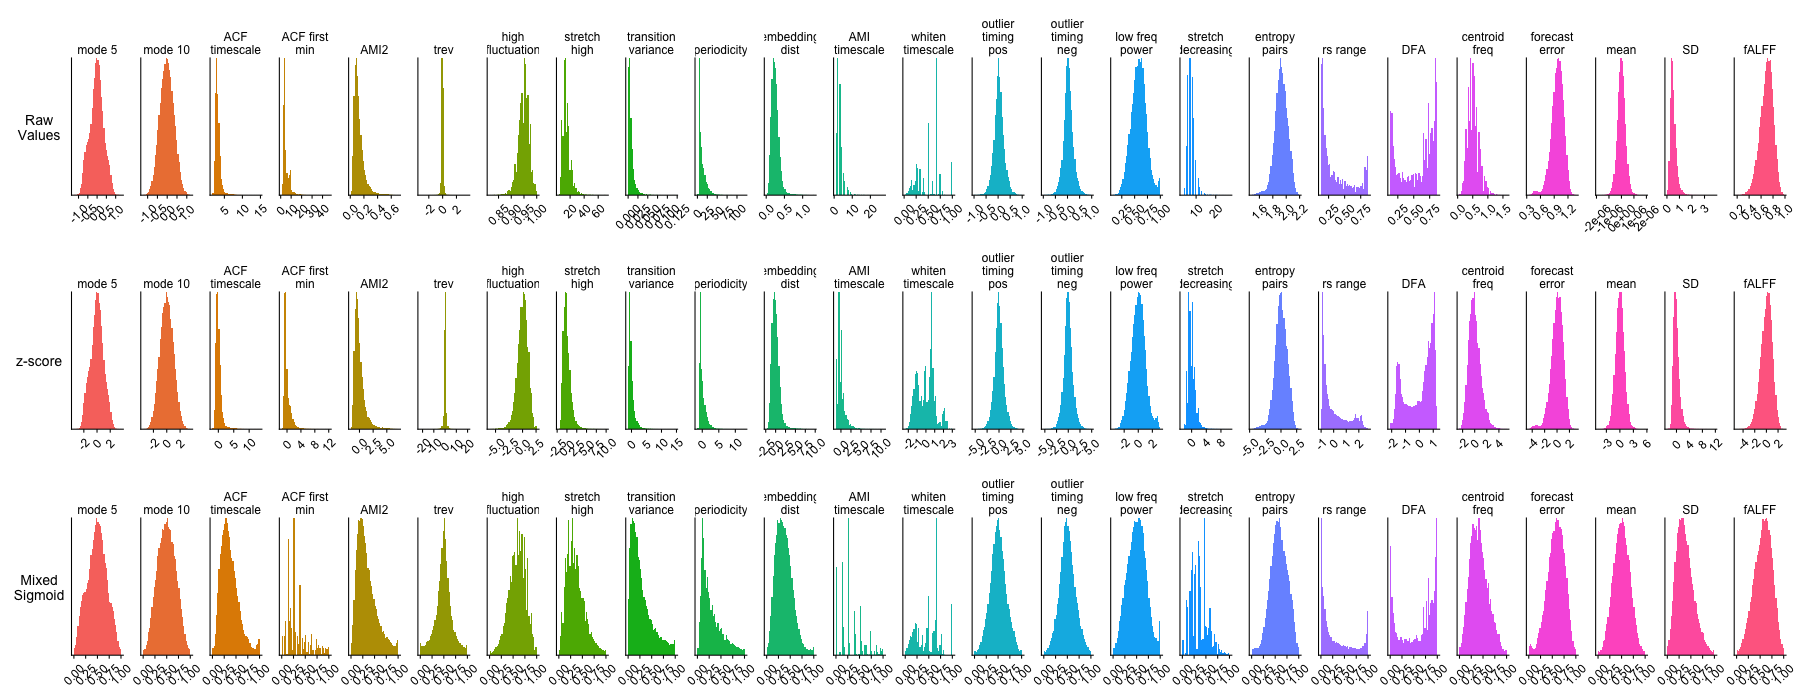

In [55]:
%%R -i count_data_for_ggplot_univariate,univariate_TS_feature_info,feature_list,color_list -w 1800 -h 700 -o ABIDE_plot_list
ABIDE_plot_list <- list()
for (i in 1:25) {
  feature <- feature_list[i]
  
  for (norm in c("Raw_Values", "z-score", "MixedSigmoid")) {
    binwidth_feature <- count_data_for_ggplot_univariate %>%
      filter(names==feature, Normalisation==norm, Study=="ABIDE") %>%
      group_by(names, Normalisation, Study) %>%
      summarise(data_range = max(bin_center) - min(bin_center), .groups="keep")

    p_ABIDE <- count_data_for_ggplot_univariate %>%
      filter(names==feature, Study=="ABIDE", Normalisation==norm) %>%
      left_join(., univariate_TS_feature_info, by=c("names" = "feature_name")) %>%
      mutate(Figure_name = gsub("_", " ", Figure_name)) %>%
      ggplot(data=., mapping=aes(x=bin_center,
                                 y=count_normalised,
                                 fill=names)) +
      geom_bar(stat="identity", width=0.026*binwidth_feature$data_range,
               fill = color_list[i]) +
      facet_wrap(. ~ Figure_name, scales="free",
                 labeller = labeller(Figure_name = label_wrap_gen(10))) +
      theme(legend.position = "none",
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            axis.title.y = element_text(angle=0, vjust=0.5),
            axis.text.x = element_text(angle=45, vjust=0.5),
            axis.title.x = element_blank(),
            strip.background = element_blank()) + 
      scale_y_continuous(expand = c(0, 0)) 

    if (i == 1) {
      p_ABIDE <- p_ABIDE  +
        ylab(ifelse(norm=="MixedSigmoid", "Mixed\nSigmoid", gsub("_", "\n", norm))) 
    } else {
      p_ABIDE <- p_ABIDE +
        theme(axis.title.y = element_blank())
    }
    ABIDE_plot_list <- list.append(ABIDE_plot_list, p_ABIDE)
  }
}

# Wrap ABIDE plots
wrapped_ABIDE <- wrap_plots(ABIDE_plot_list, nrow=3, byrow=F)
print(wrapped_ABIDE)

Then, we'll create the same visualizations for the 14 inter-regional SPIs evaluated here.

In addition: There were 42 warnings (use warnings() to see them)


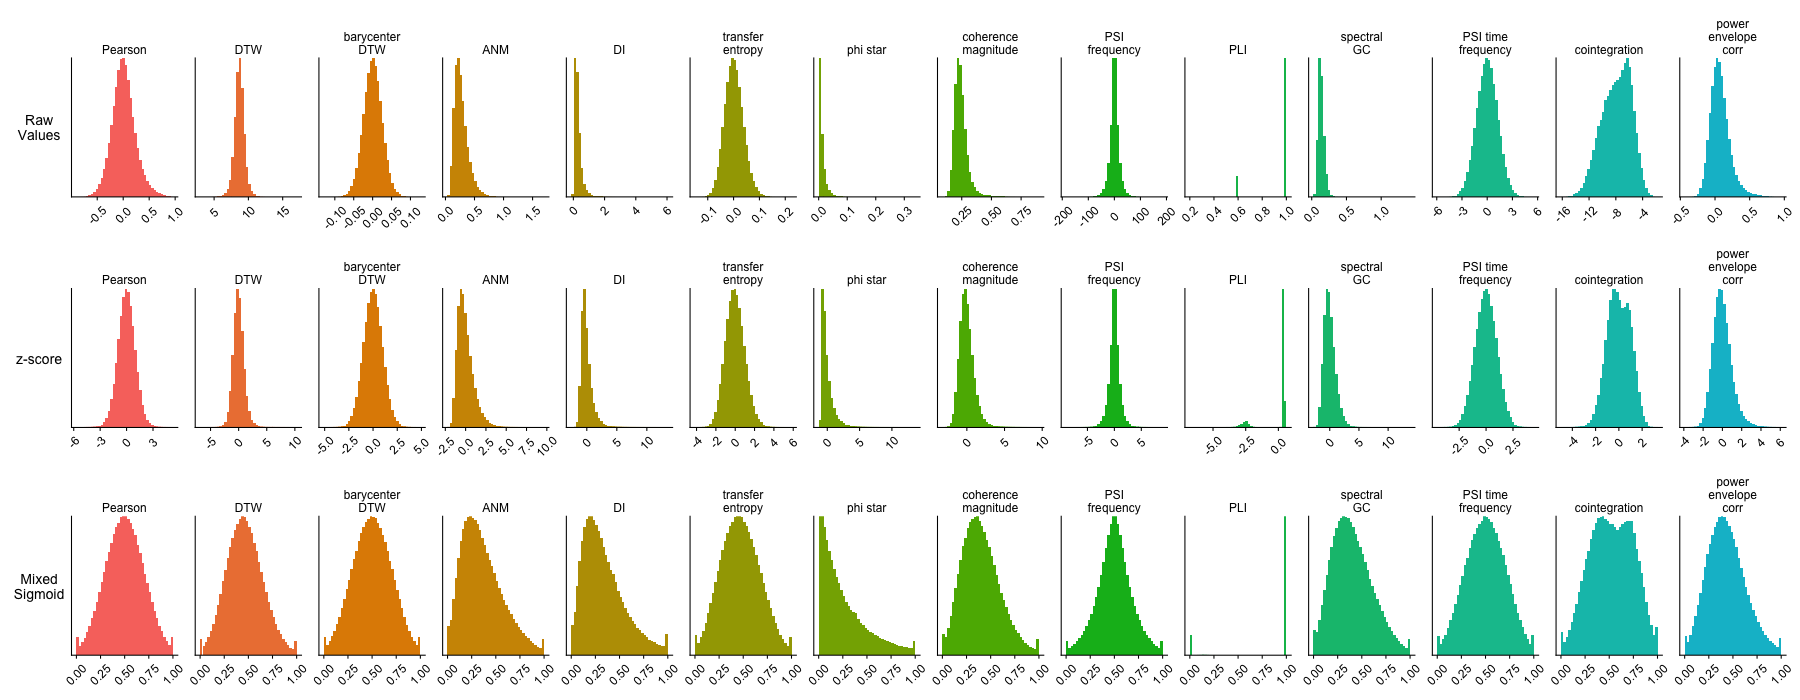

In [56]:
%%R -i normalization_binned_data,pairwise_TS_feature_info,gg_color_hue -w 1800 -h 700 -o count_data_for_ggplot_pairwise,SPI_color_list,SPI_list

# Tabulate the normalized counts for all univariate time-series features by normalization method
count_data_for_ggplot_pairwise <- normalization_binned_data %>%
  filter(names %in% pairwise_TS_feature_info$pyspi_name) %>%
  mutate(bin = gsub("\\[|\\]", "", bin)) %>%
  separate(bin, into=c("lower","upper"), sep=", ") %>%
  rowwise() %>%
  mutate(bin_center = mean(c(as.numeric(lower), as.numeric(upper))), 
         .keep = "unused") %>%
  group_by(names, Normalisation, Study) %>%
  mutate(max_count = max(count)) %>%
  rowwise() %>%
  mutate(count_normalised = count/max_count) 

# Store a list of the feature names and their corresponding ggplot color
SPI_list <- unique(count_data_for_ggplot_pairwise$names)
SPI_color_list <- gg_color_hue(length(SPI_list))

# Iterate over each feature and make one histogram per normalization method

UCLA_plot_list <- list()

for (i in 1:length(SPI_list)) {
  SPI <- SPI_list[i]
  
  for (norm in c("Raw_Values", "z-score", "MixedSigmoid")) {
    binwidth_feature <- count_data_for_ggplot_pairwise %>%
      filter(names==SPI, Normalisation==norm, Study=="UCLA_CNP") %>%
      group_by(names, Normalisation, Study) %>%
      summarise(data_range = max(bin_center) - min(bin_center), .groups="keep")
    
    p_UCLA_CNP <- count_data_for_ggplot_pairwise %>%
      filter(names==SPI, Study=="UCLA_CNP", Normalisation==norm) %>%
      left_join(., pairwise_TS_feature_info, by=c("names" = "pyspi_name")) %>%
      mutate(Figure_name = gsub("_", " ", Figure_name)) %>%
      ggplot(data=., mapping=aes(x=bin_center,
                                 y=count_normalised,
                                 fill=names)) +
      geom_bar(stat="identity", width=0.026*binwidth_feature$data_range,
               fill = color_list[i]) +
      facet_wrap(. ~ Figure_name, scales="free",
                 labeller = labeller(Figure_name = label_wrap_gen(10))) +
      theme(legend.position = "none",
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            axis.title.y = element_text(angle=0, vjust=0.5),
            axis.text.x = element_text(angle=45, vjust=0.5),
            axis.title.x = element_blank(),
            strip.background = element_blank()) + 
      scale_y_continuous(expand = c(0, 0)) 
    
    if (i == 1) {
      p_UCLA_CNP <- p_UCLA_CNP  +
        ylab(ifelse(norm=="MixedSigmoid", "Mixed\nSigmoid", gsub("_", "\n", norm))) 
    } else {
      p_UCLA_CNP <- p_UCLA_CNP +
        theme(axis.title.y = element_blank())
    }
    
    UCLA_plot_list <- list.append(UCLA_plot_list, p_UCLA_CNP)
  }
}

# Wrap UCLA CNP plots
wrapped_UCLA <- wrap_plots(UCLA_plot_list, nrow=3, byrow=F)
print(wrapped_UCLA)

In addition: There were 42 warnings (use warnings() to see them)


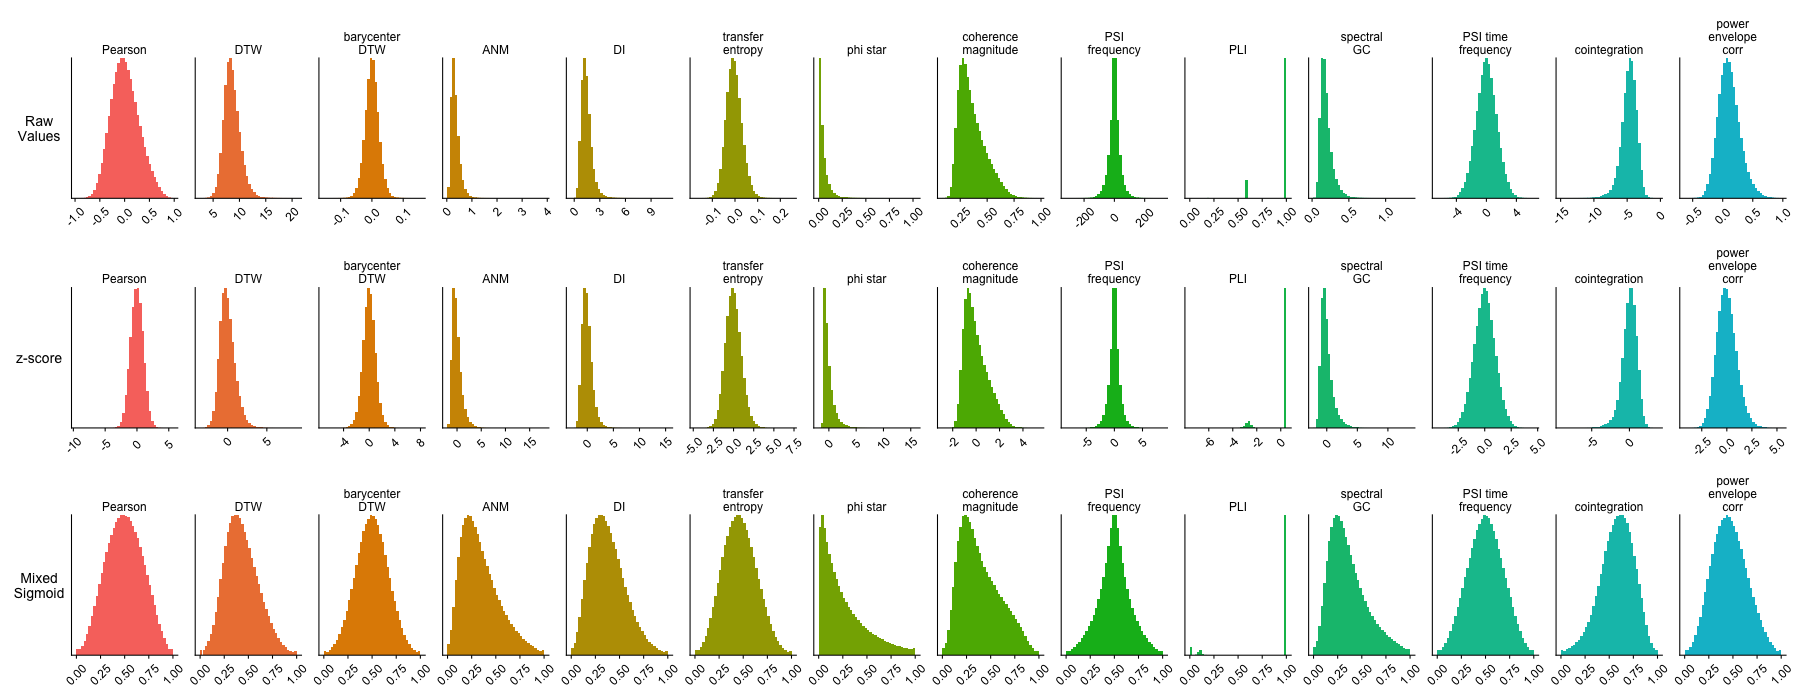

In [57]:
%%R -i count_data_for_ggplot_pairwise,SPI_color_list,SPI_list,pairwise_TS_feature_info -w 1800 -h 700

# Iterate over each feature and make one histogram per normalization method
ABIDE_plot_list <- list()

for (i in 1:length(SPI_list)) {
  SPI <- SPI_list[i]
  
  for (norm in c("Raw_Values", "z-score", "MixedSigmoid")) {
    binwidth_feature <- count_data_for_ggplot_pairwise %>%
      filter(names==SPI, Normalisation==norm, Study=="ABIDE") %>%
      group_by(names, Normalisation, Study) %>%
      summarise(data_range = max(bin_center) - min(bin_center), .groups="keep")
    
    p_ABIDE <- count_data_for_ggplot_pairwise %>%
      filter(names==SPI, Study=="ABIDE", Normalisation==norm) %>%
      left_join(., pairwise_TS_feature_info, by=c("names" = "pyspi_name")) %>%
      mutate(Figure_name = gsub("_", " ", Figure_name)) %>%
      ggplot(data=., mapping=aes(x=bin_center,
                                 y=count_normalised,
                                 fill=names)) +
      geom_bar(stat="identity", width=0.026*binwidth_feature$data_range,
               fill = color_list[i]) +
      facet_wrap(. ~ Figure_name, scales="free",
                 labeller = labeller(Figure_name = label_wrap_gen(10))) +
      theme(legend.position = "none",
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            axis.title.y = element_text(angle=0, vjust=0.5),
            axis.text.x = element_text(angle=45, vjust=0.5),
            axis.title.x = element_blank(),
            strip.background = element_blank()) + 
      scale_y_continuous(expand = c(0, 0)) 
    
    if (i == 1) {
      p_ABIDE <- p_ABIDE  +
        ylab(ifelse(norm=="MixedSigmoid", "Mixed\nSigmoid", gsub("_", "\n", norm))) 
    } else {
      p_ABIDE <- p_ABIDE +
        theme(axis.title.y = element_blank())
    }
    
    ABIDE_plot_list <- list.append(ABIDE_plot_list, p_ABIDE)
  }
}

# Wrap UCLA CNP plots
wrapped_ABIDE <- wrap_plots(ABIDE_plot_list, nrow=3, byrow=F)
print(wrapped_ABIDE)